# Data gathering 

## Récupération des données et mise en forme avant analyse 
### Appel des bibliothèques

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
import io

import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from statsmodels.tsa.seasonal import seasonal_decompose



import folium

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

import optuna
from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance
import shap
from pdpbox import pdp

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from sklearn.model_selection import cross_val_score

####  Fonction pour récupérer automatiquement les fichiers csv et les stocker dans un df 
##### Les csv ont été préalablement téléchargés du site internet de la LFB 

In [12]:
def importer_csv_en_dataframes(chemin_dossier):
    """
    Importe tous les fichiers CSV situés dans un dossier donné en tant que DF distincts

    chemin_dossier (str): chemin d'accès au dossier contenant les fichiers CSV

    Res: List[DF]: liste de DF, un par fichier CSV
    """
    dataframes = []  # Liste pour stocker les DataFrames

    fichiers_csv = [fichier for fichier in os.listdir(chemin_dossier) if fichier.endswith('.csv')] # Liste des fichiers CSV dans le dossier

    for fichier in fichiers_csv:
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        dataframes.append(pd.read_csv(chemin_fichier))  

    return dataframes

# Appel de la fonction :
chemin_dossier = "C:/Users/rymat/Documents/Data London"  
dataframes_importes = importer_csv_en_dataframes(chemin_dossier)



#### Attribution des noms de df 

In [13]:
LFB_Incidents = dataframes_importes[0]
LFB_Mobilisations = dataframes_importes[1]

In [ ]:
# Observation des df
print(LFB_Incidents.columns)
print(LFB_Mobilisations.columns)

#### # Extraction des fichiers de métadonnées en raw 

In [14]:
#Installation de pip install openpyxl


chemin_fichier1 = 'C:/Users/rymat/Documents/Data London/Metadata/Metadata_incidents.xlsx'  
chemin_fichier2 = 'C:/Users/rymat/Documents/Data London/Metadata/Metadata_mob.xlsx'  

# Chargement 
Metadata_incidents = pd.read_excel(chemin_fichier1)
Metadata_mob = pd.read_excel(chemin_fichier2)

In [15]:
# Observation des df de métadonnées 
Metadata_incidents
Metadata_mob

,Column,Sample record,Description
0,IncidentNumber,000008-01012018,LFB Incident Number
1,CalYear,2018,Year of 999 call
2,HourOfCall,3,Hour of 999 call
3,ResourceMobilisationId,5055153,LFB Resource Mobilisation ID
4,Resource_Code,A392,LFB Resource Code
5,PerformanceReporting,1,First Pump arrived at incident
6,DateAndTimeMobilised,01/01/2018 00:04:25,Date and time of mobilised (GMT)
7,DateAndTimeMobile,01/01/2018 00:05:38,Date and time of mobile (GMT)
8,DateAndTimeArrived,01/01/2018 00:10:13,Date and time arrived (GMT)
9,TurnoutTimeSeconds,73,Turnout time in seconds


In [16]:
# Constat : Il y a une colonne supplémentaire dans LFB_incidents par rapport aux colonnes disponibles dans le dataframe 
# des métadonnées. 

# Suppression de la dernière colonne 
LFB_Incidents = LFB_Incidents.iloc[:, :-1]


#### Récupération des colonnes du df des métadonnées et attribution des noms au df des incidents

In [17]:
noms_col_inc = Metadata_incidents.iloc[:, 0].tolist()
noms_col_inc

LFB_Incidents.columns = noms_col_inc

#### Attribution des noms de colonnes pour le df des mobilisations 

In [18]:
noms_col_mob = Metadata_mob.iloc[:, 0].tolist()
noms_col_mob

LFB_Mobilisations.columns = noms_col_mob
#LFB_Mobilisations

#### Extraction des tables brutes traitées 

In [ ]:
LFB_Mobilisations.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/Base globale/LFB_Mobilisations.csv', index=False)
LFB_Incidents.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/Base globale/LFB_Incidents.csv', index=False)

#### Infos rapides sur les 2 df

In [13]:
print('LFB_Mobilisations \n',LFB_Mobilisations.info())
print('\n LFB_Incidents \n',LFB_Incidents.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227677 entries, 0 to 2227676
Data columns (total 22 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   IncidentNumber            object 
 1   CalYear                   int64  
 2   HourOfCall                int64  
 3   ResourceMobilisationId    int64  
 4   Resource_Code             object 
 5   PerformanceReporting      object 
 6   DateAndTimeMobilised      object 
 7   DateAndTimeMobile         object 
 8   DateAndTimeArrived        object 
 9   TurnoutTimeSeconds        float64
 10  TravelTimeSeconds         float64
 11  AttendanceTimeSeconds     int64  
 12  DateAndTimeLeft           object 
 13  DateAndTimeReturned       object 
 14  DeployedFromStation_Code  object 
 15  DeployedFromStation_Name  object 
 16  DeployedFromLocation      object 
 17  PumpOrder                 int64  
 18  PlusCode_Code             object 
 19  PlusCode_Description      object 
 20  DelayCodeId             

## Premières analyses 
### Analyse des champs 
#### Types de données

In [ ]:
# Incidents
type_inc = LFB_Incidents.dtypes
#print(type_inc)
type_inc.to_csv('type_inc.csv')

# Mobilisations
type_mob = LFB_Mobilisations.dtypes
#print(type_mob)
type_mob.to_csv('type_mob.csv')

#### Gestion des NAs et cleaning des variables 

In [8]:
# Répartition des nan values 

# Au global 
# Pour les incidents 
nan_tot_inc = (LFB_Incidents.isna().sum().sum() / LFB_Incidents.size) * 100
print("Global nan Incidents :", nan_tot_inc, "%")

# Pour les mobilisations 
nan_tot_mob = (LFB_Mobilisations.isna().sum().sum() / LFB_Mobilisations.size) * 100
print("Global nan Mobilisations :", nan_tot_mob, "%")


# Par variable
# Pour les incidents 
LFB_Incidents.isna()
size_inc= LFB_Incidents.shape
nan_values_inc= LFB_Incidents.isna().sum()
nan_values_inc= nan_values_inc.sort_values(ascending=True)*100/size_inc[0]
print('Incidents nan values\n', nan_values_inc)

# Pour les mobilisations 
LFB_Mobilisations.isna()
size_mob= LFB_Mobilisations.shape
nan_values_mob= LFB_Mobilisations.isna().sum()
nan_values_mob= nan_values_mob.sort_values(ascending=True)*100/size_mob[0]
print('\n Mobilisations nan values\n', nan_values_mob)



Global nan Incidents : 12.57202292281901 %
Global nan Mobilisations : 9.665994502956952 %
Incidents nan values
 IncidentNumber                             0.000000
PumpCount                                  0.000000
FRS                                        0.000000
Northing_rounded                           0.000000
Easting_rounded                            0.000000
PumpHoursRoundUp                           0.000000
ProperCase                                 0.000000
IncGeo_BoroughName                         0.000000
IncGeo_BoroughCode                         0.000000
Postcode_district                          0.000000
Notional Cost (£)                          0.000000
TimeOfCall                                 0.000000
PropertyType                               0.000000
DateOfCall                                 0.000000
PropertyCategory                           0.000000
CalYear                                    0.000000
StopCodeDescription                        0.000000
Inci

#### Suppression des heures non multiples de 60

In [19]:
def supprimer_non_multiples_de_60(dataframe, colonne_temps):
    # Utilisation de l'opérateur modulo (%) pour filtrer les lignes
    dataframe_filtre = dataframe[dataframe[colonne_temps] % 60 == 0]
    return dataframe_filtre


LFB_Incidents_filtre = supprimer_non_multiples_de_60(LFB_Incidents, 'PumpHoursRoundUp')
LFB_Incidents_filtre

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£)
0,1091,01 Jan 2009,2009,00:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN,1,60,255
1,2091,01 Jan 2009,2009,00:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0,1,60,255
2,3091,01 Jan 2009,2009,00:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0,1,60,255
3,5091,01 Jan 2009,2009,00:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0,2,60,255
4,6091,01 Jan 2009,2009,00:06:03,0,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,...,Kentish Town,172.0,Kentish Town,222.0,Kentish Town,1.0,2.0,2,60,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602828,115287-31072023,31 Jul 2023,2023,23:15:07,23,Special Service,Special Service,No action (not false alarm),Non Residential,Airport - terminal,...,Heathrow,760.0,Heathrow,NaN,NaN,1.0,1.0,1,60,388
1602830,115292-31072023,31 Jul 2023,2023,23:39:37,23,Special Service,Special Service,Lift Release,Non Residential,Restaurant/cafe,...,Soho,NaN,NaN,NaN,NaN,1.0,1.0,1,60,388
1602831,115293-31072023,31 Jul 2023,2023,23:39:40,23,Special Service,Special Service,Effecting entry/exit,Non Residential,Public toilets,...,Dagenham,383.0,Dagenham,NaN,NaN,1.0,1.0,1,60,388
1602832,115296-31072023,31 Jul 2023,2023,23:44:08,23,Special Service,Special Service,RTC,Outdoor Structure,Roadside furniture (eg lamp posts/ road signs/...,...,Hainault,239.0,Hainault,564.0,Woodford,2.0,2.0,2,60,388


#### Cleaning des Nas

In [20]:
# On drop les variables qui ne sont pas exploitables et les lignes qui ont des valeurs manquantes 

# Variables 
LFB_Incidents_d = LFB_Incidents_filtre.drop(['SpecialServiceType', 'SecondPumpArriving_DeployedFromStation', 'SecondPumpArriving_AttendanceTime',
                                   'Postcode_full', 'Easting_m', 'Longitude', 'Latitude', 'Northing_m', 'UPRN', 'USRN', 
                                   'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 
                                   'FRS', 'Easting_rounded', 'Northing_rounded'], axis = 1)

LFB_Mobilisations_d = LFB_Mobilisations.drop(['DateAndTimeReturned','DelayCodeId', 'DelayCode_Description'], axis = 1)

# Lignes 
LFB_Incidents_d=LFB_Incidents_d.dropna(axis=0, how='any')
LFB_Mobilisations_d=LFB_Mobilisations_d.dropna(axis=0, how='any')

In [12]:
nombre_de_lignes, nombre_de_colonnes = LFB_Incidents_d.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

nombre_de_lignes, nombre_de_colonnes = LFB_Mobilisations_d.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 1287593
Nombre de colonnes : 21
Nombre de lignes : 2156847
Nombre de colonnes : 19


In [ ]:
LFB_Mobilisations_d.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/Raw data/LFB_Mobilisations_d.csv', index=False)
LFB_Incidents_d.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/Raw data/LFB_Incidents_d.csv', index=False)

#### Petites analyses supplémentaires 

In [ ]:
# Croisement de certaines variables via des tableaux de contingence. 

def cont(Variable1, Variable2, df): 
    tableau_contingence = pd.crosstab(df[Variable1], df[Variable2])
    tableau_contingence.to_csv(f'tableau_contingence_{Variable1}_{Variable2}.csv')
    return print(f"Tableau de contingence des variables '{Variable1}' et '{Variable2}':\n", tableau_contingence, "\n" )  

cont('IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', LFB_Incidents_d)

#cont('ResourceMobilisationId', 'Resource_Code', LFB_Mobilisations)
# trop de ressource machine


In [ ]:
# Petites manipulations pour comprendre les interactions entre les variables et la granularité
LFB_Incidents_d.loc[(LFB_Incidents['PumpHoursRoundUp'] == 60) & (LFB_Incidents['DateOfCall'] == '01 Jan 2009') ,
                  ['NumStationsWithPumpsAttending', 'HourOfCall', 'PumpHoursRoundUp', 'CalYear', 'TimeOfCall', 'DateOfCall', 'IncidentNumber', 'PumpCount']]
# groupe = LFB_Incidents.groupby('IncidentStationGround')['PumpCount'].sum().reset_index()
#LFB_Incidents['UPRN'] = LFB_Incidents['UPRN'].astype('object')
#LFB_Incidents['USRN'] = LFB_Incidents['UPRN'].astype('object')
#print(LFB_Incidents['PumpHoursRoundUp'].unique())


### Statistiques descriptives 

In [ ]:
def calculer_statistiques_descriptives(dataframe, chemin_export_excel, nom):
    """
    Calcule les statistiques descriptives pour un DF donné et les exporte dans un classeur Excel.

    Args: DF contenant les données.
          chemin_export_excel: Le chemin où enregistrer les statistiques dans un classeur Excel.

    Res : None
    """
   
    statistiques = dataframe.describe()
    
    if not os.path.exists(chemin_export_excel):
        os.makedirs(chemin_export_excel)
        
    # Classeur Excel et ajout des statistiques dans une feuille
    classeur = Workbook()
    feuille = classeur.active
    feuille.title = "Statistiques descriptives"

    
    feuille.append(['Statistiques'] + statistiques.columns.tolist())
    for ligne in dataframe_to_rows(statistiques, index=True, header=False):
        feuille.append(list(ligne))
        
    # Save 
    nom_classeur_excel = f"{nom}.xlsx"
    chemin_classeur_excel = os.path.join(chemin_export_excel, nom_classeur_excel)
    classeur.save(chemin_classeur_excel)

    
    
calculer_statistiques_descriptives(LFB_Incidents_d,"C:/Users/rymat/Documents/Data London/Export", "Incidents" )
calculer_statistiques_descriptives(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export", 'Mobilisations')

In [ ]:
# Check de la distribution entre Incidents et Incidents filtrée
statistiques = LFB_Incidents_d.describe()
statistiques

In [ ]:
# Easting_m a presque 50% de valeurs manquantes et Easting_rounded qui est censé être construit à partir de Easting_m 
# n'a aucune valeur manquante => aberrant
#LFB_Incidents.loc[LFB_Incidents['Easting_m'].isna(), ['Easting_m', 'Easting_rounded']]
#print(LFB_Incidents['NumPumpsAttending'].unique())
groupe = LFB_Incidents_d.groupby('ProperCase')['PumpCount'].sum().reset_index()
groupe

### Distribution

#### Histogrammes des variables numériques 

In [ ]:
def enregistrer_histogrammes_dans_excel(dataframe, chemin_export_excel):
    """
    Crée un classeur Excel séparé pour chaque histogramme de variable numérique dans un DF.

    Args: DF contenant les variables numériques.
          chemin_export_excel: Le répertoire où enregistrer les classeurs Excel.
    """
    # Sélection des colonnes numériques
    variables_numeriques = dataframe.select_dtypes(include=['number'])

    # Vérif si le répertoire d'exportation existe, sinon on le crée
    if not os.path.exists(chemin_export_excel):
        os.makedirs(chemin_export_excel)

    # Classeur Excel séparé pour chaque histogramme
    for colonne in variables_numeriques.columns:
        plt.figure(figsize=(8, 6))
        plt.hist(dataframe[colonne], bins=20, color='blue', alpha=0.3)
        plt.title(f'Histogramme de {colonne}')
        plt.xlabel(colonne)
        plt.ylabel('Fréquence')

        # Enregistrement au format PNG dans le répertoire spécifié
        nom_fichier_png = f'histogramme_{colonne}.png'
        chemin_fichier_png = os.path.join(chemin_export_excel, nom_fichier_png)
        plt.savefig(chemin_fichier_png, format='png')
        plt.close()

        # Création d'un nouveau classeur Excel
        classeur = Workbook()
        feuille = classeur.active

        # Insertion de l'histogramme 
        image = Image(chemin_fichier_png)
        feuille.add_image(image, 'A1')

        # Enregistrement du classeur Excel avec le nom de la colonne
        nom_classeur_excel = f'histogramme_{colonne}.xlsx'
        chemin_classeur_excel = os.path.join(chemin_export_excel, nom_classeur_excel)
        classeur.save(chemin_classeur_excel)
        os.remove(chemin_fichier_png)

# Spéc du répertoire complet où les classeurs Excel doivent être exportés
rep_exp_incidents = "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti"   
rep_exp_mobilisations = "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti"

# Appel de la fonction pour enregistrer les histogrammes 
enregistrer_histogrammes_dans_excel(LFB_Incidents_d, rep_exp_incidents)
enregistrer_histogrammes_dans_excel(LFB_Mobilisations_d, rep_exp_mobilisations)

#### Histogramme par groupe 

In [ ]:
def plot_histogram_and_save(dataframe, column_name, output_file):
    """
    Prend en entrée un DF, le nom d'une colonne,
    compte les effectifs de la table en fonction des modalités de la colonne,
    puis sauvegarde l'histogramme dans un fichier spécifié.

    Args: DF contenant les données.
          column_name: Le nom de la colonne par laquelle on souhaite grouper
          output_file: Le chemin du fichier de sortie pour sauvegarder l'histogramme.
    """
    # Vérif si la colonne existe dans le df
    if column_name not in dataframe.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")

    # Comptage des effectifs en fonction des modalités de la colonne
    counts = dataframe[column_name].value_counts()

    # Créer un histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(counts.index, counts.values)
    plt.xlabel(column_name)
    plt.ylabel('Effectif')
    plt.title(f'Histogramme de {column_name}')
    plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
    
    # Sauvegarder dans un fichier
    plt.savefig(output_file)
    plt.close()


output_file_inc = 'C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/histogramme.png'
output_file_mob = 'C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/histogramme.png'
plot_histogram_and_save(LFB_Incidents_d, 'CalYear', output_file_inc)
plot_histogram_and_save(LFB_Mobilisations_d, 'CalYear', output_file_mob)

#### Extraire les données pour le plot dans streamlit

In [ ]:
def extract_histogram_data(dataframe, column_name, output_file):
    """
    Cette fonction prend en entrée un DF et le nom d'une colonne, compte
    les effectifs de la table en fonction des modalités de la colonne, et sauvegarde
    les données dans un fichier CSV.

    Args: DF contenant les données.
          column_name: Le nom de la colonne par laquelle on souhaite grouper
          output_file: Le chemin du fichier CSV de sortie.
    """
    # Vérif si la colonne existe dans le DataFrame
    if column_name not in dataframe.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")

    # Compter les effectifs en fonction des modalités de la colonne
    counts = dataframe[column_name].value_counts()

    # Créer un df à partir des données
    histogram_data = pd.DataFrame({'Modalité': counts.index, 'Effectif': counts.values})

    # Sauvegarde
    histogram_data.to_csv(output_file, index=False)


output_file_inc = 'C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/histogram_data_inc_hour.csv'
output_file_mob = 'C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/histogram_data_mob_hour.csv'
extract_histogram_data(LFB_Incidents_d, 'HourOfCall', output_file_inc)
extract_histogram_data(LFB_Mobilisations_d, 'HourOfCall', output_file_mob)


#### Histogramme stacked 

In [ ]:
def plot_stacked_histogram_and_save(dataframe, column_name, stacked_column, output_file):
    """
    Cette fonction prend en entrée un DF, le nom d'une colonne,
    le nom de la colonne pour l'empilement, compte les effectifs de la table en fonction des modalités de la colonne,
    puis sauvegarde l'histogramme empilé dans un fichier spécifié.

    Args: DF contenant les données.
          column_name: Le nom de la colonne par laquelle on souhaite grouper
          stacked_column: Le nom de la colonne pour l'empilement
          output_file: Le chemin du fichier de sortie pour sauvegarder l'histogramme.
    """
    # Vérif si les colonnes existent dans le df
    if column_name not in dataframe.columns or stacked_column not in dataframe.columns:
        raise ValueError("Au moins l'une des colonnes spécifiées n'existe pas dans le DataFrame.")

    # Compter les effectifs en fonction des modalités de la colonne
    grouped_data = dataframe.groupby(stacked_column)[column_name].value_counts().unstack(fill_value=0)

    # Créer un histogramme empilé
    plt.figure(figsize=(14, 6))
    ax = grouped_data.plot(kind='bar', stacked=True)
    plt.xlabel(stacked_column)
    plt.ylabel('Effectif')
    plt.title(f"Histogramme empilé des types d'incidents par année")
    plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe x pour meilleure lisibilité
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6)
    plt.tight_layout()
    # Sauvegarde dans un fichier
    plt.savefig(output_file)
    plt.close()



output_file_inc = 'C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/histogramme_empile.png'
output_file_mob = 'C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/histogramme_empile.png'
plot_stacked_histogram_and_save(LFB_Incidents_d, 'StopCodeDescription', 'CalYear', output_file_inc)
#plot_stacked_histogram_and_save(df, 'Classe', 'Groupe', output_file)

### Etendue des valeurs 
#### Matrice de corrélation 

In [ ]:
def creer_images_correlation(dataframe, chemin_export_images):
    """
    Crée une image de la matrice de corrélation pour les variables numériques d'un DF et l'exporte.

    Args: DF contenant les données
          chemin_export_images: Le chemin où enregistrer l'image.

    Res:None
    """
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    plt.figure(figsize=(16, 16))
    corr_matrix = variables_numeriques.corr()
    sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    nom_fichier_png = 'matrice_correlation.png'
    chemin_fichier_png = f'{chemin_export_images}/{nom_fichier_png}'
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()

creer_images_correlation(LFB_Incidents_d, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti" )
creer_images_correlation(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti" )

#### Export des données brutes pour corrélation dans streamlit (trop lourd)

In [ ]:
def export_data_for_correlation(dataframe, chemin_export_csv):
    """
    Exporte les données brutes simplifiées pour la création de la matrice de corrélation.

    Args: DF contenant les données
          chemin_export_csv: Le chemin où enregistrer le fichier CSV.

    Res:None
    """
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    variables_numeriques.to_csv(chemin_export_csv, index=False)


export_data_for_correlation(LFB_Incidents_d, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti/data_for_correlation_inc.csv" )
export_data_for_correlation(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti/data_for_correlation_mob.csv" )


#### Matrice de dispersion 

In [ ]:
def creer_matrice_dispersion(dataframe, chemin_export_images):
    """
    Crée une image de la matrice de dispersion pour les variables numériques d'un DF et exporte l'image.

    Args: DF contenant les données
          chemin_export_images: Le chemin où enregistrer l'image.

    Res: None
    """
    plt.figsize=(14, 14)
    variables_numeriques = dataframe.select_dtypes(include=['number'])
    sns.pairplot(diag_kind = 'kde', data = variables_numeriques)
    #pd.plotting.scatter_matrix(variables_numeriques, figsize=(14, 14), diagonal='hist')
    plt.suptitle("Matrice de Dispersion")
    nom_fichier_png = 'matrice_dispersion.png'
    chemin_fichier_png = f'{chemin_export_images}/{nom_fichier_png}'
    plt.savefig(chemin_fichier_png, format='png')
    plt.close()

creer_matrice_dispersion(LFB_Incidents_d, "C:/Users/rymat/Documents/Data London/Export/Incidents/Quanti" )
creer_matrice_dispersion(LFB_Mobilisations_d, "C:/Users/rymat/Documents/Data London/Export/Mobilisations/Quanti" )

### Tests statistiques et représentations associées 
#### Par mois
##### Représentations graphiques 

In [21]:
LFB_Incidents_d['Date'] = pd.to_datetime(LFB_Incidents_d['DateOfCall'])
LFB_Incidents_d['Mois'] = LFB_Incidents_d['Date'].dt.month
LFB_Incidents_d['Jour_de_la_semaine'] = LFB_Incidents_d['Date'].dt.day_name()

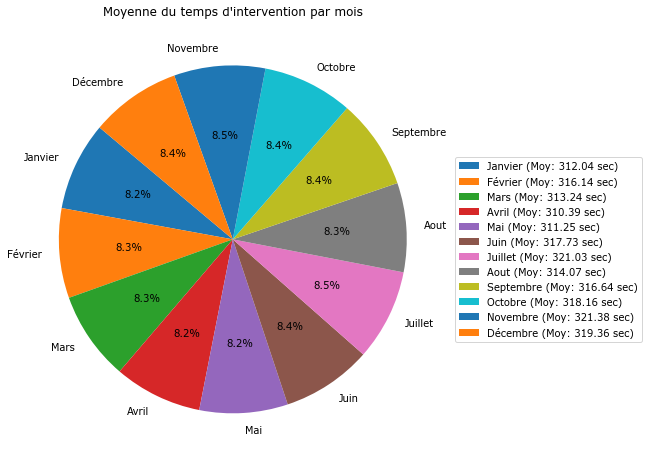

In [15]:
monthly_mean_time = LFB_Incidents_d.groupby('Mois')['FirstPumpArriving_AttendanceTime'].mean()
months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(monthly_mean_time, labels=months, autopct='%1.1f%%', startangle=140)
plt.title('Moyenne du temps d\'intervention par mois')

#legend_labels = [f"{months[i]} (Moy: {monthly_mean_time[i]:.2f} min)" for i in range(len(months))]
legend_labels = [f"{month} (Moy: {mean:.2f} sec)" for month, mean in zip(months, monthly_mean_time)]
plt.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 0.7))
plt.show()

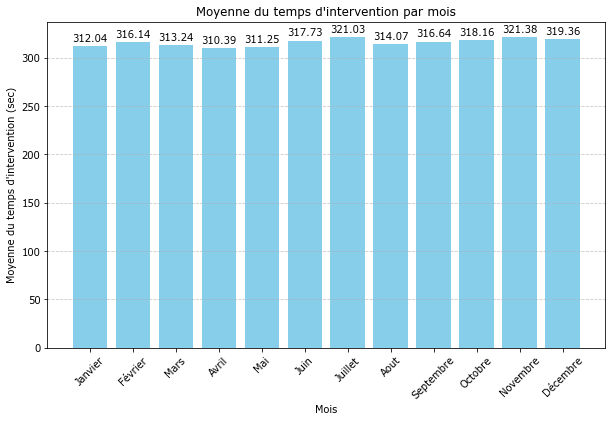

In [16]:
# 'monthly_mean_time' contient la moyenne du temps d'intervention par mois
# 'months' est une liste de noms de mois
monthly_mean_time = LFB_Incidents_d.groupby('Mois')['FirstPumpArriving_AttendanceTime'].mean()
months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

# Espacement supplémentaire entre les barres
bar_width = 0.8

# Légendes  
plt.figure(figsize=(10, 6))
bars = plt.bar(months, monthly_mean_time, color='skyblue', width=bar_width)  # Ajuster la largeur des barres
plt.xlabel('Mois')
plt.ylabel('Moyenne du temps d\'intervention (sec)')
plt.title('Moyenne du temps d\'intervention par mois')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Res au-dessus des barres
for bar, mean in zip(bars, monthly_mean_time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{mean:.2f}', ha='center', color='black')

plt.show()


##### Test statistique 

In [18]:
# Séparer les temps d'intervention par mois en listes distinctes
monthly_data = [LFB_Incidents_d[LFB_Incidents_d['Mois'] == month]['FirstPumpArriving_AttendanceTime'] for month in range(1, 13)]

# ANOVA
f_statistic, p_value = f_oneway(*monthly_data)

# Res
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les mois.")
    print("Cela signifie que le temps d'intervention varie en fonction du mois de l'année.")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les mois.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction du mois de l'année.")

f statistic: 80.46816007306143 p_value: 1.120431674796777e-182
L'ANOVA montre qu'il existe une différence statistiquement significative entre les mois.
Cela signifie que le temps d'intervention varie en fonction du mois de l'année.


#### Par jour 

##### Représentation graphique 

In [19]:
print(LFB_Incidents_d['Jour_de_la_semaine'])

1          Thursday
2          Thursday
3          Thursday
4          Thursday
5          Thursday
             ...   
1602827      Monday
1602828      Monday
1602831      Monday
1602832      Monday
1602833      Monday
Name: Jour_de_la_semaine, Length: 1287593, dtype: object


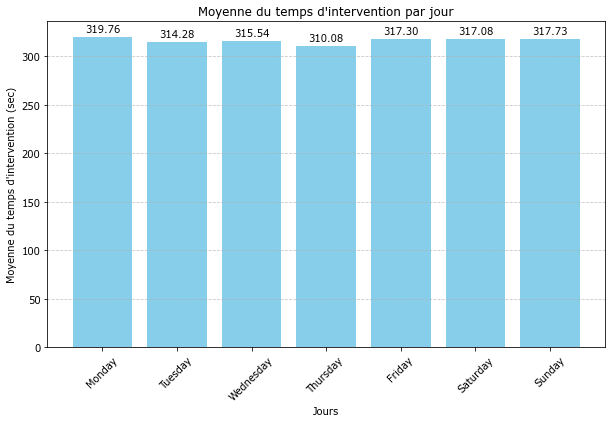

In [20]:
daily_mean_time = LFB_Incidents_d.groupby('Jour_de_la_semaine')['FirstPumpArriving_AttendanceTime'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Espacement supplémentaire entre les barres
bar_width = 0.8

# Légendes
plt.figure(figsize=(10, 6))
bars = plt.bar(days, daily_mean_time, color='skyblue', width=bar_width)  # Ajuster la largeur des barres
plt.xlabel('Jours')
plt.ylabel('Moyenne du temps d\'intervention (sec)')
plt.title('Moyenne du temps d\'intervention par jour')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Res au-dessus des barres
for bar, mean in zip(bars, daily_mean_time):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{mean:.2f}', ha='center', color='black')

plt.show()

In [43]:
LFB_Incidents_d['Date'] = pd.to_datetime(LFB_Incidents_d['DateOfCall'])  # colonne est de type datetime

# Crée une nouvelle colonne pour le jour de la semaine en num
LFB_Incidents_d['Jour_de_la_semaine'] = LFB_Incidents_d['Date'].dt.day_name()
LFB_Incidents_d['Numero_jour'] = LFB_Incidents_d["Date"].dt.dayofweek
print(LFB_Incidents_d['Numero_jour'])

1          3
2          3
3          3
4          3
5          3
          ..
1602827    0
1602828    0
1602831    0
1602832    0
1602833    0
Name: Numero_jour, Length: 1287593, dtype: int32


##### Test statistique 

In [22]:
# Séparer les temps d'intervention par mois en listes distinctes
daily_data = [LFB_Incidents_d[LFB_Incidents_d['Jour_de_la_semaine'] == day]['FirstPumpArriving_AttendanceTime'] for day in range(1, 8)]

# ANOVA
f_statistic, p_value = f_oneway(*daily_data)

# Res
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les jours.")
    print("Cela signifie que le temps d'intervention varie en fonction du jour de la semaine.")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les jours.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction du jour de la semaine.")

f statistic: nan p_value: nan
L'ANOVA n'a pas trouvé de différence statistiquement significative entre les jours.
Cela suggère que le temps d'intervention ne varie pas considérablement en fonction du jour de la semaine.


#### Par heure

##### Représentation graphique 

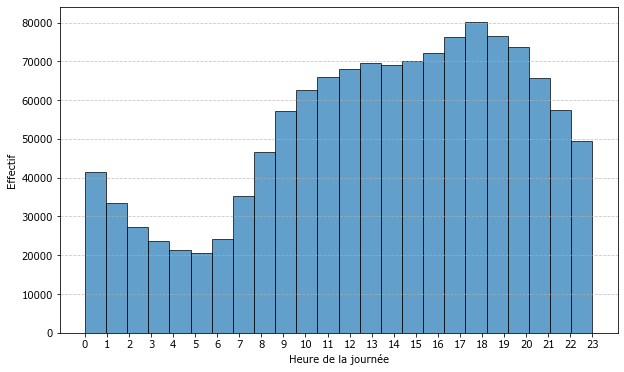

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(LFB_Incidents_d['HourOfCall'], bins=24, edgecolor='k', alpha=0.7)
plt.xlabel('Heure de la journée')
plt.ylabel('Effectif')
#plt.title('Histogramme du temps d\'intervention par heure de la journée')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Test statistique 

In [24]:
# Séparer les temps d'intervention par mois en listes distinctes
hourly_data = [LFB_Incidents_d[LFB_Incidents_d['HourOfCall'] == hour]['FirstPumpArriving_AttendanceTime'] for hour in range(0, 24)]

# ANOVA
f_statistic, p_value = f_oneway(*hourly_data)

# Res
if p_value < 0.05:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA montre qu'il existe une différence statistiquement significative entre les heures.")
    print("Cela signifie que le temps d'intervention varie en fonction de l'heure de la journée")
else:
    print("f statistic:",f_statistic ,"p_value:",p_value )
    print("L'ANOVA n'a pas trouvé de différence statistiquement significative entre les heures.")
    print("Cela suggère que le temps d'intervention ne varie pas considérablement en fonction des heures de la journée.")

f statistic: 423.5404032545424 p_value: 0.0
L'ANOVA montre qu'il existe une différence statistiquement significative entre les heures.
Cela signifie que le temps d'intervention varie en fonction de l'heure de la journée


##### Histo horizontal par type d'incident 

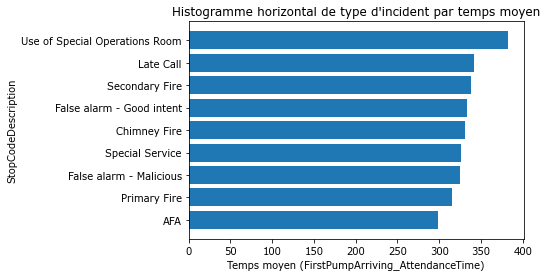

In [25]:
def plot_horizontal_histogram(data, category_variable, time_variable):
    """
    Crée un histogramme horizontal des moyennes de temps par catégorie.

    Args: data (pandas.DataFrame): Le DataFrame contenant les données.
          category_variable (str): Le nom de la variable catégorielle (axe des ordonnées).
          time_variable (str): Le nom de la variable de temps (axe des abscisses).

    Res: None
    """
    # Moyenne du temps pour chaque catégorie
    category_means = data.groupby(category_variable)[time_variable].mean()
    category_means = category_means.sort_values(ascending=True)
    
   
    fig, ax = plt.subplots()

    # Histogramme horizontal
    ax.barh(category_means.index, category_means.values)

    # Etiquettes des axes
    ax.set_xlabel(f"Temps moyen ({time_variable})")
    ax.set_ylabel(category_variable)
    ax.set_title(f"Histogramme horizontal de type d'incident par temps moyen")

    
    plt.show()



plot_horizontal_histogram(LFB_Incidents_d, category_variable='StopCodeDescription', time_variable='FirstPumpArriving_AttendanceTime')



#### Test de stationarité 

In [26]:
def test_stationarity(data_frame, column_name, freq):
    # Regrouper les données par mois et calculer la moyenne mensuelle
    monthly_data = data_frame.resample('M')[column_name].mean()

    # ADF sur les données mensuelles
    result = adfuller(monthly_data.dropna())  # Supprimer les valeurs manquantes

    # Res
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'Résultats du test ADF pour la série {column_name} (fréquence: {freq}):')
    print(f'Statistique ADF : {adf_statistic}')
    print(f'p-value : {p_value}')
    print('Valeurs critiques :')
    for key, value in critical_values.items():
        print(f'    {key}: {value}')

    
    if p_value <= 0.05:
        print(f'La série {column_name} est stationnaire (p-value <= 0.05)')
    else:
        print(f'La série {column_name} n\'est pas stationnaire (p-value > 0.05)')

# On s'assure que l'index est basé sur la colonne 'Date'
LFB_Incidents_d.set_index('Date', inplace=True)


test_stationarity(LFB_Incidents_d, 'FirstPumpArriving_AttendanceTime', 'mensuelle')


Résultats du test ADF pour la série FirstPumpArriving_AttendanceTime (fréquence: mensuelle):
Statistique ADF : -3.2185825321090786
p-value : 0.018933933594991802
Valeurs critiques :
    1%: -3.4691814633722453
    5%: -2.878595143532943
    10%: -2.5758625549741803
La série FirstPumpArriving_AttendanceTime est stationnaire (p-value <= 0.05)


### Réduction de la base aux seules données renseignées 

In [44]:
LFB_Incidents_sub=LFB_Incidents_filtre.dropna(subset=['Latitude'])

In [45]:
nombre_de_lignes, nombre_de_colonnes = LFB_Incidents_sub.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 726790
Nombre de colonnes : 38


In [ ]:
calculer_statistiques_descriptives(LFB_Incidents_sub,"C:/Users/rymat/Documents/Data London/Export", "Incidents sub" )

### Répartition géographique des interventions

In [ ]:
def create_intervention_time_map(data):
    """
    Crée une carte de Londres colorée en fonction de la durée moyenne du temps d'intervention par district.

    Args: DF contenant les données de localisation, de district et de temps d'intervention

    Returns: folium.Map: La carte de Londres avec les couleurs des districts en fonction du temps d'intervention moyen.
    """
    # Regrouper les données par district et calculer la durée moyenne d'intervention
    district_means = data.groupby('ProperCase')['FirstPumpArriving_AttendanceTime'].mean()

    # Créer une carte de Londres centrée sur un point arbitraire
    london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

    # Palette de couleurs en fonction du temps d'intervention moyen
    colors = ['green', 'yellow', 'orange', 'red']
    district_colors = pd.cut(district_means, bins=[0, 180, 360, 540, float('inf')], labels=colors)

    # Ajouter les districts à la carte avec des couleurs en fonction du temps moyen
    for district, color in zip(district_means.index, district_colors):
        folium.CircleMarker(
            location=data[data['ProperCase'] == district][['Latitude', 'Longitude']].mean(),
            radius=10,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f"ProperCase: {district}<br>Temps moyen d'intervention: {district_means[district]:.2f} minutes"
        ).add_to(london_map)

    # Légende
    legend_html = """
    <div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; font-size:14px;">
      <p><strong>Légende</strong></p>
      <p><span style="background-color: green; padding: 5px; border-radius: 50%;"></span> < 3 min</p>
      <p><span style="background-color: yellow; padding: 5px; border-radius: 50%;"></span> 3 min - 6 min</p>
      <p><span style="background-color: orange; padding: 5px; border-radius: 50%;"></span> 6 min - 9 min</p>
      <p><span style="background-color: red; padding: 5px; border-radius: 50%;"></span> > 9 min</p>
    </div>
    """
    london_map.get_root().html.add_child(folium.Element(legend_html))

    return london_map


  
    london_intervention_map = create_intervention_time_map(LFB_Incidents_sub)

    
    london_intervention_map.save('london_intervention_map.html')


### Création de la base de travail 

In [46]:
indices_max_var = LFB_Mobilisations_d.groupby('IncidentNumber')['PumpOrder'].idxmax()

# Sélection des lignes correspondantes en utilisant les indices
LFB_Mobilisations_d2 = LFB_Mobilisations_d.loc[indices_max_var]

In [47]:
nombre_de_lignes, nombre_de_colonnes = LFB_Incidents_d.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

nombre_de_lignes, nombre_de_colonnes = LFB_Mobilisations_d2.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 1287593
Nombre de colonnes : 25
Nombre de lignes : 1437641
Nombre de colonnes : 19


In [48]:
# Jointure des 2 tables via l'id incident

database = LFB_Incidents_d.merge(right = LFB_Mobilisations_d2, on = 'IncidentNumber', how = 'inner')
database.info()


#on resupprime les lignes manquantes car la jointure a pu rapporter des lignes avec na 
database=database.dropna(axis=0, how='any')

# on supprime les proxy et la variable d'heure supplémentaire
database = database.drop(['TravelTimeSeconds', 'AttendanceTimeSeconds', 'HourOfCall_y', 'CalYear_y'], axis = 1)

database.describe().to_csv('stats_desc_database.csv')
print(database.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237733 entries, 0 to 1237732
Data columns (total 43 columns):
 #   Column                                 Non-Null Count    Dtype         
---  ------                                 --------------    -----         
 0   IncidentNumber                         1237733 non-null  object        
 1   DateOfCall                             1237733 non-null  object        
 2   CalYear_x                              1237733 non-null  int64         
 3   TimeOfCall                             1237733 non-null  object        
 4   HourOfCall_x                           1237733 non-null  int64         
 5   IncidentGroup                          1237733 non-null  object        
 6   StopCodeDescription                    1237733 non-null  object        
 7   PropertyCategory                       1237733 non-null  object        
 8   PropertyType                           1237733 non-null  object        
 9   AddressQualifier                   

In [37]:
# Filtrer le df pour visualiser cohérence des résultats dans Démo streamlit
filtre = database.loc[(database['StopCodeDescription'] == "False alarm - Good intent") & 
                      (database['ProperCase'] == 'Barnet') & 
                      (database['PropertyCategory'] == 'Non Residential')].head(10)



In [39]:
filtre.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/filtre.csv', index=False)

In [46]:
nombre_de_lignes, nombre_de_colonnes = database.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)



Nombre de lignes : 1237733
Nombre de colonnes : 38


In [33]:
print(database.columns)

Index(['IncidentNumber', 'DateOfCall', 'CalYear_x', 'TimeOfCall',
       'HourOfCall_x', 'IncidentGroup', 'StopCodeDescription',
       'PropertyCategory', 'PropertyType', 'AddressQualifier',
       'Postcode_district', 'IncGeo_BoroughCode', 'ProperCase',
       'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'Mois', 'Jour_de_la_semaine',
       'Numero_jour', 'ResourceMobilisationId', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'TurnoutTimeSeconds', 'DateAndTimeLeft',
       'DeployedFromStation_Code', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code',
       'PlusCode_Description'],
      dtype='object')


### Suppression des variables redondantes ou non utiles 

In [49]:
database = database.drop(['IncidentNumber', 'TimeOfCall', 'AddressQualifier', 'Postcode_district', 
                         'IncGeo_BoroughCode', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 
                         'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', 
                         'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', 
                         'PlusCode_Description', 'PropertyType', 'FirstPumpArriving_DeployedFromStation'], axis =1)



"\ndatabase_sub = database_sub.drop(['IncidentNumber', 'TimeOfCall', 'AddressQualifier', 'Postcode_full', 'Postcode_district', \n                         'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode', 'IncGeo_WardName', \n                         'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', \n                          'FRS', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', \n                         'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'DateAndTimeLeft', \n                         'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', \n                         'PlusCode_Description', 'PropertyType', 'FirstPumpArriving_DeployedFromStation',\n                                  'SecondPumpArriving_DeployedFromStation','SpecialServiceType'], axis =1)"

In [36]:
print(database.columns)

Index(['DateOfCall', 'CalYear_x', 'HourOfCall_x', 'IncidentGroup',
       'StopCodeDescription', 'PropertyCategory', 'ProperCase',
       'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'Mois', 'Jour_de_la_semaine',
       'Numero_jour', 'TurnoutTimeSeconds', 'PumpOrder'],
      dtype='object')


In [41]:
nombre_de_lignes, nombre_de_colonnes = database.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 1237733
Nombre de colonnes : 19


#### Extraction, encodage et standardisation

In [50]:
def extract_features(data):
    """
    Fonction pour extraire et encoder le mois, l'année et le type d'intervention.

    Args: DF contenant les données

    Res: DF avec les caractéristiques extraites et encodées.
    """
    # Extraction du mois et de l'année de la colonne "Date"
    data['Date'] = pd.to_datetime(data['DateOfCall'])
    data['Mois'] = data['Date'].dt.month
    data['Année'] = data['Date'].dt.year
    data['JourSemaine_Num'] = data['Date'].dt.weekday
    
    # Encodages one-hot
    mois_dummies = pd.get_dummies(data['Mois'], prefix='Mois')
    data = pd.concat([data, mois_dummies], axis=1)
    
   
    année_dummies = pd.get_dummies(data['Année'], prefix='Année')
    data = pd.concat([data, année_dummies], axis=1)
    
   
    jour_semaine_dummies = pd.get_dummies(data['JourSemaine_Num'], prefix='JourSemaine')
    data = pd.concat([data, jour_semaine_dummies], axis=1)
    
  
    heure_dummies = pd.get_dummies(data['HourOfCall_x'], prefix='Heure')
    data = pd.concat([data, heure_dummies], axis=1)
    
    IncidentGroup_dummies = pd.get_dummies(data['IncidentGroup'], prefix='IncidentGroup')
    data = pd.concat([data, IncidentGroup_dummies], axis=1)
    
    StopCodeDescription_dummies = pd.get_dummies(data['StopCodeDescription'], prefix='StopCodeDescription')
    data = pd.concat([data, StopCodeDescription_dummies], axis=1)
    
    PropertyCategory_dummies = pd.get_dummies(data['PropertyCategory'], prefix='PropertyCategory')
    data = pd.concat([data, PropertyCategory_dummies], axis=1)
    
    ProperCase_dummies = pd.get_dummies(data['ProperCase'], prefix='ProperCase')
    data = pd.concat([data, ProperCase_dummies], axis=1)
    
    IncidentStationGround_dummies = pd.get_dummies(data['IncidentStationGround'], prefix='IncidentStationGround')
    data = pd.concat([data, IncidentStationGround_dummies], axis=1)
    
    # Supprimer les colonnes originales
    data.drop(['DateOfCall', 'Date', 'CalYear_x','HourOfCall_x', 'Mois','JourSemaine_Num','Année', 'IncidentGroup',
              'StopCodeDescription', 'PropertyCategory', 'ProperCase', 'IncidentStationGround', 'Jour_de_la_semaine', 'Numero_jour' ], axis=1, inplace=True)
    
    # Conversion des variables dummies en entiers
    dummy_columns = list(mois_dummies.columns) + list(année_dummies.columns) + list(jour_semaine_dummies.columns) \
    + list(heure_dummies.columns) + list(IncidentGroup_dummies.columns) + list(StopCodeDescription_dummies.columns) \
    + list(PropertyCategory_dummies.columns) + list(ProperCase_dummies.columns) + list(IncidentStationGround_dummies.columns) 
    data[dummy_columns] = data[dummy_columns].astype(int)
    
    return data
data_encoded = extract_features(database)

In [43]:
print(data_encoded.columns)

Index(['FirstPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending',
       'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp',
       'Notional Cost (£)', 'Jour_de_la_semaine', 'Numero_jour',
       'TurnoutTimeSeconds', 'PumpOrder',
       ...
       'IncidentStationGround_Wandsworth', 'IncidentStationGround_Wembley',
       'IncidentStationGround_Wennington',
       'IncidentStationGround_West Hampstead',
       'IncidentStationGround_West Norwood',
       'IncidentStationGround_Whitechapel', 'IncidentStationGround_Willesden',
       'IncidentStationGround_Wimbledon', 'IncidentStationGround_Woodford',
       'IncidentStationGround_Woodside'],
      dtype='object', length=224)


In [50]:
nombre_de_lignes, nombre_de_colonnes = data_encoded.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 1237733
Nombre de colonnes : 222


In [44]:
column_list = data_encoded.columns.tolist()
print(column_list)

['FirstPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp', 'Notional Cost (£)', 'Jour_de_la_semaine', 'Numero_jour', 'TurnoutTimeSeconds', 'PumpOrder', 'Mois_1', 'Mois_2', 'Mois_3', 'Mois_4', 'Mois_5', 'Mois_6', 'Mois_7', 'Mois_8', 'Mois_9', 'Mois_10', 'Mois_11', 'Mois_12', 'Année_2009', 'Année_2010', 'Année_2011', 'Année_2012', 'Année_2013', 'Année_2014', 'Année_2015', 'Année_2016', 'Année_2017', 'Année_2018', 'Année_2019', 'Année_2020', 'Année_2021', 'Année_2022', 'Année_2023', 'JourSemaine_0', 'JourSemaine_1', 'JourSemaine_2', 'JourSemaine_3', 'JourSemaine_4', 'JourSemaine_5', 'JourSemaine_6', 'Heure_0', 'Heure_1', 'Heure_2', 'Heure_3', 'Heure_4', 'Heure_5', 'Heure_6', 'Heure_7', 'Heure_8', 'Heure_9', 'Heure_10', 'Heure_11', 'Heure_12', 'Heure_13', 'Heure_14', 'Heure_15', 'Heure_16', 'Heure_17', 'Heure_18', 'Heure_19', 'Heure_20', 'Heure_21', 'Heure_22', 'Heure_23', 'IncidentGroup_False Alarm', 'IncidentGroup_Fire', 'I

In [51]:

variables_a_standardiser = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'TurnoutTimeSeconds']


scaler = StandardScaler()


data_encoded[variables_a_standardiser] = scaler.fit_transform(data_encoded[variables_a_standardiser])



In [53]:
# Récupération des moyennes et variances pour standardiser les inputs du user pour la démo streamlit
variables_a_standardiser = ['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
                            'PumpHoursRoundUp', 'Notional Cost (£)', 'TurnoutTimeSeconds']


means_dict = database[variables_a_standardiser].mean()
stds_dict = database[variables_a_standardiser].std()


print("Moyennes des variables :")
print(means_dict)
print("\nÉcarts types des variables :")
print(stds_dict)


Moyennes des variables :
NumStationsWithPumpsAttending      1.311029
NumPumpsAttending                  1.478912
PumpCount                          1.480532
PumpHoursRoundUp                  60.275488
Notional Cost (£)                311.731550
TurnoutTimeSeconds                78.760321
dtype: float64

Écarts types des variables :
NumStationsWithPumpsAttending      0.556083
NumPumpsAttending                  0.682054
PumpCount                          0.694558
PumpHoursRoundUp                  27.297307
Notional Cost (£)                143.869867
TurnoutTimeSeconds                45.250354
dtype: float64


"\nimport json\n\nwith open('scaler_params.json', 'w') as f:\n    json.dump({'means': means_dict, 'stds': stds_dict}, f)\n\ndef standardize_data(new_data, means_dict, stds_dict):\n    standardized_data = {}\n    for variable, value in new_data.items():\n        if variable in means_dict and variable in stds_dict:\n            mean = means_dict[variable]\n            std = stds_dict[variable]\n            standardized_value = (value - mean) / std\n            standardized_data[variable] = standardized_value\n        else:\n            standardized_data[variable] = value  # Ne pas standardiser si les moyennes et écarts-types ne sont pas disponibles\n    return standardized_data\n"

In [52]:
nombre_de_lignes, nombre_de_colonnes = data_encoded.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

Nombre de lignes : 1237733
Nombre de colonnes : 222


#### Extraction des données traitées 

In [78]:
data_encoded.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/Base globale/data_encoded.csv', index=False)

In [79]:
features = data_encoded.drop('FirstPumpArriving_AttendanceTime', axis=1)
target = data_encoded['FirstPumpArriving_AttendanceTime']

features.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/df/features.csv', index=False)
target.to_csv('C:/Users/rymat/Documents/Data London/Données exportées/df/target.csv', index=False)

In [10]:
chemin_dossier = "C:/Users/rymat/Documents/Data London/Données exportées/Base globale"  
dataframes_importes = importer_csv_en_dataframes(chemin_dossier)
base = dataframes_importes[0]

# Modélisation 

### Import des données extraites 

In [2]:
def importer_csv_en_dataframes(chemin_dossier):
    """
    Importe tous les fichiers CSV situés dans un dossier donné en tant que DF distincts.

    Args: chemin_dossier: Le chemin d'accès au dossier contenant les fichiers CSV.

    Res: Une liste de DF, un par fichier CSV.
    """
    dataframes = []  # Liste pour stocker les DataFrames

    fichiers_csv = [fichier for fichier in os.listdir(chemin_dossier) if fichier.endswith('.csv')] # Liste des fichiers CSV dans le dossier

    for fichier in fichiers_csv:
        chemin_fichier = os.path.join(chemin_dossier, fichier)
        dataframes.append(pd.read_csv(chemin_fichier))  

    return dataframes

# Appel de la fonction :
chemin_dossier = "C:/Users/rymat/Documents/Data London/Données exportées/df"  
dataframes_importes = importer_csv_en_dataframes(chemin_dossier)


In [3]:
features2 = dataframes_importes[0]
target2 = dataframes_importes[1]

In [4]:
nombre_de_lignes, nombre_de_colonnes = target2.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)


nombre_de_lignes, nombre_de_colonnes = features2.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)


Nombre de lignes : 1237733
Nombre de colonnes : 1
Nombre de lignes : 1237733
Nombre de colonnes : 221


In [6]:
print(features2.columns)

Index(['NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'TurnoutTimeSeconds',
       'PumpOrder', 'Mois_1', 'Mois_2', 'Mois_3',
       ...
       'IncidentStationGround_Wandsworth', 'IncidentStationGround_Wembley',
       'IncidentStationGround_Wennington',
       'IncidentStationGround_West Hampstead',
       'IncidentStationGround_West Norwood',
       'IncidentStationGround_Whitechapel', 'IncidentStationGround_Willesden',
       'IncidentStationGround_Wimbledon', 'IncidentStationGround_Woodford',
       'IncidentStationGround_Woodside'],
      dtype='object', length=221)


In [57]:
# on crée des samples pour les modèles non linéaires 

features_non_reg = features2.sample(n=10000, random_state=42)
target_non_reg = target2.sample(n=10000, random_state=42)

In [58]:
nombre_de_lignes, nombre_de_colonnes = target2.shape


print("Nombre de lignes :", nombre_de_lignes)
print("Nombre de colonnes :", nombre_de_colonnes)

print(features_non_reg)
print(target_non_reg.shape)

Nombre de lignes : 1237733
Nombre de colonnes : 1
         NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
992043                        1.238972           0.763998   0.747912   
1181617                      -0.559322          -0.702161  -0.691852   
315164                        1.238972           2.230157   2.187676   
965125                        1.238972           2.230157   2.187676   
1006014                      -0.559322          -0.702161  -0.691852   
...                                ...                ...        ...   
639044                       -0.559322           0.763998   0.747912   
64307                        -0.559322          -0.702161  -0.691852   
873234                        1.238972           2.230157   2.187676   
800261                       -0.559322          -0.702161  -0.691852   
894389                        1.238972           0.763998   0.747912   

         PumpHoursRoundUp  Notional Cost (£)  TurnoutTimeSeconds  PumpOrder  \
992043

## Régresseurs simples 

### Modèles non linéaires 

#### KNN simple

In [59]:
def knn_simple(features, target, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_knn.csv'):
    """
    Entraîne un modèle KNN simple sans spécifier d'hyperparamètres.

    Parameters:
        - features: DF des caractéristiques.
        - target: Variable cible
        - chemin export

    Returns:
        - model
        - mse_train
        - mae_train
        - r2_train
        - mse_test
        - mae_test
        - r2_test
        - feature_importance: Importances des variables basées sur la permutation.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    
    model = KNeighborsRegressor()

    
    model.fit(X_train, y_train)

    
    y_train_pred = model.predict(X_train)

    
    y_test_pred = model.predict(X_test)

    # Calculer les métriques pour l'ensemble d'entraînement
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculer les métriques pour l'ensemble de test
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Importances des variables basées sur la permutation
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = dict(zip(features.columns, result.importances_mean))

    contributions_df = pd.DataFrame.from_dict({'Variable': list(feature_importance.keys()), 'Contribution': list(feature_importance.values())})
    contributions_df.to_csv(contributions_csv_path, index=False)
    
    
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Importances des variables basées sur la permutation:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance}")

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, feature_importance

knn_simple(features_non_reg, target_non_reg)

# la fonction permutation_importance permet de calculer les importances des variables basées sur la permutation. 
#Les importances sont ensuite affichées et peuvent être interprétées comme l'impact de chaque variable sur 
#la performance du modèle.


MSE sur l'ensemble d'entraînement: 12609.73535
MSE sur l'ensemble de test: 18727.289920000003
Mean Absolute Error sur l'ensemble d'entraînement: 81.0859
Mean Absolute Error sur l'ensemble de test: 100.23339999999999
R² sur l'ensemble d'entraînement: 0.3030593976468814
R² sur l'ensemble de test: -0.034534327644031526
Importances des variables basées sur la permutation:
NumStationsWithPumpsAttending: 0.01798316721342048
NumPumpsAttending: 0.006592347321273273
PumpCount: 0.011634212822347112
PumpHoursRoundUp: -0.001270456876653747
Notional Cost (£): 0.004435412603630851
TurnoutTimeSeconds: 0.05546836256609351
PumpOrder: 0.012388068365682025
Mois_1: 0.0016050225404095064
Mois_2: 2.4683263315328218e-05
Mois_3: 0.0008965455984139448
Mois_4: 0.0018147060944084137
Mois_5: 0.0007342441652786524
Mois_6: 0.0026327951321830413
Mois_7: 0.004435934309773693
Mois_8: -0.0025178748255541895
Mois_9: -0.0008491416016891629
Mois_10: -0.007583152027893858
Mois_11: 0.015018158072553777
Mois_12: -0.002378486

(KNeighborsRegressor(),
 12609.73535,
 81.0859,
 0.3030593976468814,
 18727.289920000003,
 100.23339999999999,
 -0.034534327644031526,
 {'NumStationsWithPumpsAttending': 0.01798316721342048,
  'NumPumpsAttending': 0.006592347321273273,
  'PumpCount': 0.011634212822347112,
  'PumpHoursRoundUp': -0.001270456876653747,
  'Notional Cost (£)': 0.004435412603630851,
  'TurnoutTimeSeconds': 0.05546836256609351,
  'PumpOrder': 0.012388068365682025,
  'Mois_1': 0.0016050225404095064,
  'Mois_2': 2.4683263315328218e-05,
  'Mois_3': 0.0008965455984139448,
  'Mois_4': 0.0018147060944084137,
  'Mois_5': 0.0007342441652786524,
  'Mois_6': 0.0026327951321830413,
  'Mois_7': 0.004435934309773693,
  'Mois_8': -0.0025178748255541895,
  'Mois_9': -0.0008491416016891629,
  'Mois_10': -0.007583152027893858,
  'Mois_11': 0.015018158072553777,
  'Mois_12': -0.002378486810180913,
  'Année_2009': -0.0015944088808133694,
  'Année_2010': -0.006568089642892816,
  'Année_2011': -0.00037978450501827685,
  'Année_20

#### Random forest

In [60]:

def random_forest_simple(features, target, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_random_forest.csv'):
    """
    Entraîne un modèle Random Forest simple sans spécifier d'hyperparamètres.

    Parameters: même chose que précédemment
        
    Returns: même chose que précédemment
        
    """
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = RandomForestRegressor(random_state=42)


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Importances des variables basées sur la permutation
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = dict(zip(features.columns, result.importances_mean))

    contributions_df = pd.DataFrame.from_dict({'Variable': list(feature_importance.keys()), 'Contribution': list(feature_importance.values())})
    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Importances des variables basées sur la permutation:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance}")

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, feature_importance


random_forest_simple(features_non_reg, target_non_reg)


MSE sur l'ensemble d'entraînement: 2317.10781995
MSE sur l'ensemble de test: 16859.46943615
Mean Absolute Error sur l'ensemble d'entraînement: 34.1461425
Mean Absolute Error sur l'ensemble de test: 95.651205
R² sur l'ensemble d'entraînement: 0.8719333534820717
R² sur l'ensemble de test: 0.06864794895199988
Importances des variables basées sur la permutation:
NumStationsWithPumpsAttending: 0.006975297398188718
NumPumpsAttending: -0.00020249490627888278
PumpCount: -0.0009682770036551269
PumpHoursRoundUp: 3.444473106406498e-07
Notional Cost (£): 0.013716424928656223
TurnoutTimeSeconds: 0.11109141292900586
PumpOrder: 0.06388310078535056
Mois_1: -0.0017360653489619238
Mois_2: 0.0021256317731727647
Mois_3: -0.00026776125790141104
Mois_4: 0.0013679815261282368
Mois_5: 0.0007558585206584256
Mois_6: -0.0004849578117979814
Mois_7: 0.0007895597235185514
Mois_8: -0.0026044078903202815
Mois_9: 0.0006794646211550793
Mois_10: 0.001176856349256772
Mois_11: 0.0012503286957412096
Mois_12: -0.00029475880

(RandomForestRegressor(random_state=42),
 2317.10781995,
 34.1461425,
 0.8719333534820717,
 16859.46943615,
 95.651205,
 0.06864794895199988,
 {'NumStationsWithPumpsAttending': 0.006975297398188718,
  'NumPumpsAttending': -0.00020249490627888278,
  'PumpCount': -0.0009682770036551269,
  'PumpHoursRoundUp': 3.444473106406498e-07,
  'Notional Cost (£)': 0.013716424928656223,
  'TurnoutTimeSeconds': 0.11109141292900586,
  'PumpOrder': 0.06388310078535056,
  'Mois_1': -0.0017360653489619238,
  'Mois_2': 0.0021256317731727647,
  'Mois_3': -0.00026776125790141104,
  'Mois_4': 0.0013679815261282368,
  'Mois_5': 0.0007558585206584256,
  'Mois_6': -0.0004849578117979814,
  'Mois_7': 0.0007895597235185514,
  'Mois_8': -0.0026044078903202815,
  'Mois_9': 0.0006794646211550793,
  'Mois_10': 0.001176856349256772,
  'Mois_11': 0.0012503286957412096,
  'Mois_12': -0.0002947588094454168,
  'Année_2009': 0.0017608388294887978,
  'Année_2010': -0.00010063886972092596,
  'Année_2011': 0.00103248697712495

#### Decision tree

In [61]:
def decision_tree_simple(features, target, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_decision_tree.csv'):
    """
    Entraîne un modèle Decision Tree simple sans spécifier d'hyperparamètres.

    Parameters: même chose que précédemment
        

    Returns: même chose que précédemment
       
    """

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = DecisionTreeRegressor(random_state=42)


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Importances des variables basées sur la permutation
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = dict(zip(features.columns, result.importances_mean))

    contributions_df = pd.DataFrame.from_dict({'Variable': list(feature_importance.keys()), 'Contribution': list(feature_importance.values())})
    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Importances des variables basées sur la permutation:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance}")

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, feature_importance


decision_tree_simple(features_non_reg, target_non_reg)


MSE sur l'ensemble d'entraînement: 0.0
MSE sur l'ensemble de test: 30157.7965
Mean Absolute Error sur l'ensemble d'entraînement: 0.0
Mean Absolute Error sur l'ensemble de test: 126.8535
R² sur l'ensemble d'entraînement: 1.0
R² sur l'ensemble de test: -0.6659792131499733
Importances des variables basées sur la permutation:
NumStationsWithPumpsAttending: 0.02140605215935436
NumPumpsAttending: 0.006034992142530893
PumpCount: 0.034324220480001943
PumpHoursRoundUp: 0.0
Notional Cost (£): 0.029532219186595054
TurnoutTimeSeconds: 0.1847085904382721
PumpOrder: 0.20821771386288085
Mois_1: 0.00046508854164564186
Mois_2: -0.0005625355594341519
Mois_3: -0.004269157163837245
Mois_4: -0.0017792311815358675
Mois_5: 0.015035804158600374
Mois_6: 0.00067749707664988
Mois_7: 0.016795167528374556
Mois_8: -0.0060548185227374375
Mois_9: 0.0002580219151561591
Mois_10: 0.0050886318937855
Mois_11: -0.0005570721183574045
Mois_12: 0.004385466587648356
Année_2009: -0.003044407247408132
Année_2010: -0.017352294888

(DecisionTreeRegressor(random_state=42),
 0.0,
 0.0,
 1.0,
 30157.7965,
 126.8535,
 -0.6659792131499733,
 {'NumStationsWithPumpsAttending': 0.02140605215935436,
  'NumPumpsAttending': 0.006034992142530893,
  'PumpCount': 0.034324220480001943,
  'PumpHoursRoundUp': 0.0,
  'Notional Cost (£)': 0.029532219186595054,
  'TurnoutTimeSeconds': 0.1847085904382721,
  'PumpOrder': 0.20821771386288085,
  'Mois_1': 0.00046508854164564186,
  'Mois_2': -0.0005625355594341519,
  'Mois_3': -0.004269157163837245,
  'Mois_4': -0.0017792311815358675,
  'Mois_5': 0.015035804158600374,
  'Mois_6': 0.00067749707664988,
  'Mois_7': 0.016795167528374556,
  'Mois_8': -0.0060548185227374375,
  'Mois_9': 0.0002580219151561591,
  'Mois_10': 0.0050886318937855,
  'Mois_11': -0.0005570721183574045,
  'Mois_12': 0.004385466587648356,
  'Année_2009': -0.003044407247408132,
  'Année_2010': -0.01735229488880554,
  'Année_2011': 0.004959973104426441,
  'Année_2012': 0.0005722636885908905,
  'Année_2013': 0.0015528519261

#### GBR

In [62]:
def gbr_simple(features, target, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_gbr.csv'):
    """
    Entraîne un modèle Gradient Boosting Regressor simple sans spécifier d'hyperparamètres.

    Parameters: même chose que précédemment
        

    Returns: même chose que précédemment
        
    """

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = GradientBoostingRegressor(random_state=42)


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Importances des variables basées sur la permutation
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = dict(zip(features.columns, result.importances_mean))

    contributions_df = pd.DataFrame.from_dict({'Variable': list(feature_importance.keys()), 'Contribution': list(feature_importance.values())})
    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Importances des variables basées sur la permutation:")
    for feature, importance in feature_importance.items():
        print(f"{feature}: {importance}")

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, feature_importance


gbr_simple(features_non_reg, target_non_reg)


MSE sur l'ensemble d'entraînement: 14582.577811696216
MSE sur l'ensemble de test: 16363.55959826746
Mean Absolute Error sur l'ensemble d'entraînement: 87.32520217215934
Mean Absolute Error sur l'ensemble de test: 93.65567983439661
R² sur l'ensemble d'entraînement: 0.19402031193741254
R² sur l'ensemble de test: 0.09604303670348335
Importances des variables basées sur la permutation:
NumStationsWithPumpsAttending: 0.0004344448888961128
NumPumpsAttending: 0.0005877999014433976
PumpCount: 0.0002903584184366759
PumpHoursRoundUp: 0.0
Notional Cost (£): 0.00032070543746123283
TurnoutTimeSeconds: 0.05832146901376789
PumpOrder: 0.032897402290514924
Mois_1: -0.00034620455952432127
Mois_2: -7.457736843619056e-05
Mois_3: 5.208725243898149e-05
Mois_4: 0.0
Mois_5: 5.4845073641585086e-05
Mois_6: 3.726936319040641e-05
Mois_7: 0.0003580505530992761
Mois_8: -0.00023914924368552138
Mois_9: -7.769018396386329e-07
Mois_10: 0.0008925008245394106
Mois_11: 0.00015334930429966587
Mois_12: -3.224160561755562e-0

(GradientBoostingRegressor(random_state=42),
 14582.577811696216,
 87.32520217215934,
 0.19402031193741254,
 16363.55959826746,
 93.65567983439661,
 0.09604303670348335,
 {'NumStationsWithPumpsAttending': 0.0004344448888961128,
  'NumPumpsAttending': 0.0005877999014433976,
  'PumpCount': 0.0002903584184366759,
  'PumpHoursRoundUp': 0.0,
  'Notional Cost (£)': 0.00032070543746123283,
  'TurnoutTimeSeconds': 0.05832146901376789,
  'PumpOrder': 0.032897402290514924,
  'Mois_1': -0.00034620455952432127,
  'Mois_2': -7.457736843619056e-05,
  'Mois_3': 5.208725243898149e-05,
  'Mois_4': 0.0,
  'Mois_5': 5.4845073641585086e-05,
  'Mois_6': 3.726936319040641e-05,
  'Mois_7': 0.0003580505530992761,
  'Mois_8': -0.00023914924368552138,
  'Mois_9': -7.769018396386329e-07,
  'Mois_10': 0.0008925008245394106,
  'Mois_11': 0.00015334930429966587,
  'Mois_12': -3.224160561755562e-05,
  'Année_2009': 0.0005682874152913465,
  'Année_2010': -0.0004642893771095724,
  'Année_2011': 4.366537336272236e-05,


### Modèles linéaires 

#### Régression linéaire

In [63]:

def linear_regression_simple(features, target, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_linear_regression.csv'):
    """
    Entraîne un modèle de régression linéaire simple.

    Parameters: même chose que précédemment 
      

    Returns: même chose que précédemment
             contributions_df: DF des contributions de la régression linéaire.
    """

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = LinearRegression()


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    contributions = {'Variable': [], 'Coefficient': []}
    for variable, coefficient in zip(features.columns, model.coef_[0]):
        contributions['Variable'].append(variable)
        contributions['Coefficient'].append(coefficient)


    contributions_df = pd.DataFrame(contributions)


    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Contributions de la régression linéaire:")
    print(contributions_df)

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, contributions_df


linear_regression_simple(features2, target2)


MSE sur l'ensemble d'entraînement: 15897.780096511451
MSE sur l'ensemble de test: 15811.70326354002
Mean Absolute Error sur l'ensemble d'entraînement: 89.7554263321487
Mean Absolute Error sur l'ensemble de test: 89.65378272863335
R² sur l'ensemble d'entraînement: 0.13608533619985264
R² sur l'ensemble de test: 0.1355664883820933
Contributions de la régression linéaire:
                              Variable   Coefficient
0        NumStationsWithPumpsAttending  1.389988e+01
1                    NumPumpsAttending -1.076042e+00
2                            PumpCount -2.019845e+01
3                     PumpHoursRoundUp  9.644159e-01
4                    Notional Cost (£)  2.348033e+00
..                                 ...           ...
216  IncidentStationGround_Whitechapel -1.078965e+13
217    IncidentStationGround_Willesden -1.078965e+13
218    IncidentStationGround_Wimbledon -1.078965e+13
219     IncidentStationGround_Woodford -1.078965e+13
220     IncidentStationGround_Woodside -1.0789

(LinearRegression(),
 15897.780096511451,
 89.7554263321487,
 0.13608533619985264,
 15811.70326354002,
 89.65378272863335,
 0.1355664883820933,
                               Variable   Coefficient
 0        NumStationsWithPumpsAttending  1.389988e+01
 1                    NumPumpsAttending -1.076042e+00
 2                            PumpCount -2.019845e+01
 3                     PumpHoursRoundUp  9.644159e-01
 4                    Notional Cost (£)  2.348033e+00
 ..                                 ...           ...
 216  IncidentStationGround_Whitechapel -1.078965e+13
 217    IncidentStationGround_Willesden -1.078965e+13
 218    IncidentStationGround_Wimbledon -1.078965e+13
 219     IncidentStationGround_Woodford -1.078965e+13
 220     IncidentStationGround_Woodside -1.078965e+13
 
 [221 rows x 2 columns])

#### Ridge 

In [64]:

def ridge_regression_simple(features, target, alpha=1.0, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_ridge_regression.csv'):
    """
    Entraîne un modèle de régression Ridge simple.

    Parameters: même chose que précédemment
                alpha: Paramètre de régularisation Ridge.
        

    Returns: même chose que précédemment
        
    """

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = Ridge(alpha=alpha)


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    contributions = {'Variable': [], 'Coefficient': []}
    for variable, coefficient in zip(features.columns, model.coef_[0]):
        contributions['Variable'].append(variable)
        contributions['Coefficient'].append(coefficient)


    contributions_df = pd.DataFrame(contributions)


    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Contributions de la régression Ridge:")
    print(contributions_df)

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, contributions_df


ridge_regression_simple(features2, target2)


MSE sur l'ensemble d'entraînement: 15897.560697576404
MSE sur l'ensemble de test: 15811.22583526294
Mean Absolute Error sur l'ensemble d'entraînement: 89.75586426183081
Mean Absolute Error sur l'ensemble de test: 89.65307683242204
R² sur l'ensemble d'entraînement: 0.1360972587422491
R² sur l'ensemble de test: 0.13559258961832454
Contributions de la régression Ridge:
                              Variable  Coefficient
0        NumStationsWithPumpsAttending    13.884742
1                    NumPumpsAttending    -1.137897
2                            PumpCount   -20.204051
3                     PumpHoursRoundUp     1.055865
4                    Notional Cost (£)     2.261152
..                                 ...          ...
216  IncidentStationGround_Whitechapel   -55.365513
217    IncidentStationGround_Willesden     7.243371
218    IncidentStationGround_Wimbledon   -20.511257
219     IncidentStationGround_Woodford   -14.030064
220     IncidentStationGround_Woodside    27.550814

[221 r

(Ridge(),
 15897.560697576404,
 89.75586426183081,
 0.1360972587422491,
 15811.22583526294,
 89.65307683242204,
 0.13559258961832454,
                               Variable  Coefficient
 0        NumStationsWithPumpsAttending    13.884742
 1                    NumPumpsAttending    -1.137897
 2                            PumpCount   -20.204051
 3                     PumpHoursRoundUp     1.055865
 4                    Notional Cost (£)     2.261152
 ..                                 ...          ...
 216  IncidentStationGround_Whitechapel   -55.365513
 217    IncidentStationGround_Willesden     7.243371
 218    IncidentStationGround_Wimbledon   -20.511257
 219     IncidentStationGround_Woodford   -14.030064
 220     IncidentStationGround_Woodside    27.550814
 
 [221 rows x 2 columns])

#### Lasso

In [65]:

def lasso_regression_simple(features, target, alpha=1.0, contributions_csv_path='C:/Users/rymat/Documents/Data London/Contributions modèles simples/contributions_lasso_regression.csv'):
    """
    Entraîne un modèle de régression Lasso simple.

    Parameters: même chose que précédemment

    Returns: même chose que précédemment
        
    """

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


    model = Lasso(alpha=alpha)


    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)


    y_test_pred = model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    contributions = {'Variable': [], 'Coefficient': []}
    for variable, coefficient in zip(features.columns, model.coef_):
        contributions['Variable'].append(variable)
        contributions['Coefficient'].append(coefficient)


    contributions_df = pd.DataFrame(contributions)


    contributions_df.to_csv(contributions_csv_path, index=False)
    

    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    print("Contributions de la régression Ridge:")
    print(contributions_df)

    return model, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test, contributions_df


lasso_regression_simple(features2, target2)


MSE sur l'ensemble d'entraînement: 17020.41783721647
MSE sur l'ensemble de test: 16913.99301273272
Mean Absolute Error sur l'ensemble d'entraînement: 94.02229742932518
Mean Absolute Error sur l'ensemble de test: 93.8964601042969
R² sur l'ensemble d'entraînement: 0.07507913279014777
R² sur l'ensemble de test: 0.07530377140382516
Contributions de la régression Ridge:
                              Variable  Coefficient
0        NumStationsWithPumpsAttending     6.313592
1                    NumPumpsAttending    -0.000000
2                            PumpCount   -12.473869
3                     PumpHoursRoundUp     1.015849
4                    Notional Cost (£)     0.000000
..                                 ...          ...
216  IncidentStationGround_Whitechapel    -0.000000
217    IncidentStationGround_Willesden     0.000000
218    IncidentStationGround_Wimbledon     0.000000
219     IncidentStationGround_Woodford     0.000000
220     IncidentStationGround_Woodside     0.000000

[221 ro

(Lasso(),
 17020.41783721647,
 94.02229742932518,
 0.07507913279014777,
 16913.99301273272,
 93.8964601042969,
 0.07530377140382516,
                               Variable  Coefficient
 0        NumStationsWithPumpsAttending     6.313592
 1                    NumPumpsAttending    -0.000000
 2                            PumpCount   -12.473869
 3                     PumpHoursRoundUp     1.015849
 4                    Notional Cost (£)     0.000000
 ..                                 ...          ...
 216  IncidentStationGround_Whitechapel    -0.000000
 217    IncidentStationGround_Willesden     0.000000
 218    IncidentStationGround_Wimbledon     0.000000
 219     IncidentStationGround_Woodford     0.000000
 220     IncidentStationGround_Woodside     0.000000
 
 [221 rows x 2 columns])

## Retravail de la base de données pour le gridsearch

In [5]:
features3 = features2[["NumStationsWithPumpsAttending", "PumpCount", "PumpHoursRoundUp", "TurnoutTimeSeconds", "PumpOrder",
"StopCodeDescription_AFA", "StopCodeDescription_False alarm - Good intent", "PropertyCategory_Non Residential",
"PropertyCategory_Other Residential", "PropertyCategory_Outdoor", "PropertyCategory_Road Vehicle", "ProperCase_Barnet",
"ProperCase_Bromley", "ProperCase_Camden", "ProperCase_Enfield", "ProperCase_Hillingdon", "ProperCase_Kensington And chelsea",
"ProperCase_Lambeth", "ProperCase_Southwark", "ProperCase_Tower Hamlets"]]
target3 = target2

#### Régression linéaire 

In [67]:
def linear_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle de régression linéaire.

    Parameters:
        - X: Les caractéristiques d'entraînement.
        - y: La variable cible.

    Returns:
        - best_params: Les meilleurs hyperparamètres trouvés.
        - best_model: Le meilleur modèle linéaire entraîné.
        - mse_train 
        - mse_test
        - mae_train
        - mae_test
        - r2_train
        - r2_test
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [None, -1],
        'positive': [False, True]
    }


    linear_reg = LinearRegression()


    grid_search = GridSearchCV(linear_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')


    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_


    y_train_pred = best_model.predict(X_train)


    y_test_pred = best_model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


linear_regression_grid_search(features3, target3)


Meilleurs hyperparamètres: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
MSE sur l'ensemble d'entraînement: 16712.381514417695
MSE sur l'ensemble de test: 16606.01306511346
Mean Absolute Error sur l'ensemble d'entraînement: 92.97357104356774
Mean Absolute Error sur l'ensemble de test: 92.84764510271661
R² sur l'ensemble d'entraînement: 0.09181839416081772
R² sur l'ensemble de test: 0.09214118500760249


({'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False},
 LinearRegression(),
 16712.381514417695,
 16606.01306511346,
 92.97357104356774,
 92.84764510271661,
 0.09181839416081772,
 0.09214118500760249)

#### Ridge 

In [68]:
def ridge_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle ridge.

    Parameters: même chose que précédemment
      
    Returns: même chose que précédemment
        
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0], 
        'fit_intercept': [True, False],
        'max_iter': [100, 200, 300],
        'solver': ['auto']
    }


    ridge_reg = Ridge()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_


    y_train_pred = best_model.predict(X_train)


    y_test_pred = best_model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


ridge_regression_grid_search(features3, target3)


Meilleurs hyperparamètres: {'alpha': 10.0, 'fit_intercept': True, 'max_iter': 100, 'solver': 'auto'}
MSE sur l'ensemble d'entraînement: 16712.381558253473
MSE sur l'ensemble de test: 16606.014237634932
Mean Absolute Error sur l'ensemble d'entraînement: 92.97359039735996
Mean Absolute Error sur l'ensemble de test: 92.84766700681435
R² sur l'ensemble d'entraînement: 0.09181839177870066
R² sur l'ensemble de test: 0.09214112090528304


({'alpha': 10.0, 'fit_intercept': True, 'max_iter': 100, 'solver': 'auto'},
 Ridge(alpha=10.0, max_iter=100),
 16712.381558253473,
 16606.014237634932,
 92.97359039735996,
 92.84766700681435,
 0.09181839177870066,
 0.09214112090528304)

#### Lasso

In [69]:
def lasso_regression_grid_search(X, y):
    """
    Effectue une recherche sur la grille des hyperparamètres pour un modèle lasso.

    Parameters: même chose que précédemment
        

    Returns: même chose que précédemment
       
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Paramètres à tester
    param_grid = {
        'alpha': [0.1, 1.0, 10.0, 100.0], 
        'fit_intercept': [True, False],
        'max_iter': [100, 200, 300],
        'selection': ['random']
    }

    # Initialiser le modèle de régression Lasso
    lasso_reg = Lasso()

    # Initialiser GridSearchCV
    grid_search = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

    # Exécuter la recherche sur la grille des hyperparamètres
    grid_search.fit(X_train, y_train)

   # Obtenir les meilleurs hyperparamètres
    best_params = grid_search.best_params_

    # Obtenir le meilleur modèle de régression 
    best_model = grid_search.best_estimator_


    y_train_pred = best_model.predict(X_train)


    y_test_pred = best_model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

  
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)


    print("Meilleurs hyperparamètres:", best_params)
    print("MSE sur l'ensemble d'entraînement:", mse_train)
    print("MSE sur l'ensemble de test:", mse_test)
    print("Mean Absolute Error sur l'ensemble d'entraînement:", mae_train)
    print("Mean Absolute Error sur l'ensemble de test:", mae_test)
    print("R² sur l'ensemble d'entraînement:", r2_train)
    print("R² sur l'ensemble de test:", r2_test)

    return best_params, best_model, mse_train, mse_test, mae_train, mae_test, r2_train, r2_test


lasso_regression_grid_search(features3, target3)


Meilleurs hyperparamètres: {'alpha': 0.1, 'fit_intercept': True, 'max_iter': 100, 'selection': 'random'}
MSE sur l'ensemble d'entraînement: 16715.463283274985
MSE sur l'ensemble de test: 16609.147256165135
Mean Absolute Error sur l'ensemble d'entraînement: 92.97721379146489
Mean Absolute Error sur l'ensemble de test: 92.85192105106944
R² sur l'ensemble d'entraînement: 0.09165092516262463
R² sur l'ensemble de test: 0.09196983725766539


({'alpha': 0.1, 'fit_intercept': True, 'max_iter': 100, 'selection': 'random'},
 Lasso(alpha=0.1, max_iter=100, selection='random'),
 16715.463283274985,
 16609.147256165135,
 92.97721379146489,
 92.85192105106944,
 0.09165092516262463,
 0.09196983725766539)

## Optimisation bayésienne 

### Réduction de la totalité de la base aux seuls champs contributifs 

In [6]:
features4 = features3[["NumStationsWithPumpsAttending", "PumpCount", "PumpHoursRoundUp", "TurnoutTimeSeconds", "PumpOrder",
"StopCodeDescription_AFA", "StopCodeDescription_False alarm - Good intent", "PropertyCategory_Non Residential",
"PropertyCategory_Other Residential", "PropertyCategory_Outdoor", "PropertyCategory_Road Vehicle", "ProperCase_Barnet",
"ProperCase_Bromley", "ProperCase_Camden", "ProperCase_Enfield", "ProperCase_Hillingdon", "ProperCase_Kensington And chelsea",
"ProperCase_Lambeth", "ProperCase_Southwark", "ProperCase_Tower Hamlets"]]
target4 = target3

In [7]:
features4, target4 = make_regression(n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features3, target3, test_size=0.2, random_state=42)

#### Régression linéaire 

In [8]:
regressor_lin = None

def objective(trial):
    global regressor_lin  # Déclarer regressor_lin comme global pour le modifier à l'intérieur de la fonction
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])
    n_jobs = trial.suggest_categorical('n_jobs', [None, -1])
    positive = trial.suggest_categorical('positive', [False, True])
    
    regressor_lin = LinearRegression(
        fit_intercept=fit_intercept,
        copy_X=copy_X,
        n_jobs=n_jobs,
        positive=positive
    )
    
    regressor_lin.fit(X_train, y_train)
    
    y_pred = regressor_lin.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')  # 'maximize' car on veut maximiser le R2

# Lancer l'optimisation
study.optimize(objective, n_trials=100)

# Afficher les meilleurs hyperparamètres
best_params = study.best_params
print("Meilleurs hyperparamètres (Régression Linéaire):", best_params)

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_fit_intercept = best_params['fit_intercept']
best_copy_X = best_params['copy_X']
best_n_jobs = best_params['n_jobs']
best_positive = best_params['positive']

final_regressor = LinearRegression(
    fit_intercept=best_fit_intercept,
    copy_X=best_copy_X,
    n_jobs=best_n_jobs,
    positive=best_positive
)
final_regressor.fit(X_train, y_train)

# Faire des prédictions avec le modèle final
final_predictions = final_regressor.predict(X_test)
final_predictions_train = final_regressor.predict(X_train)


final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)


final_r2_train = r2_score(y_train, final_predictions_train)
final_mae_train = mean_absolute_error(y_train, final_predictions_train)
final_mse_train = mean_squared_error(y_train, final_predictions_train)


print("R2 final train (Régression Linéaire):", final_r2_train)
print("MAE final train (Régression Linéaire):", final_mae_train)
print("MSE final train (Régression Linéaire):", final_mse_train)

print("R2 final test (Régression Linéaire):", final_r2)
print("MAE final test (Régression Linéaire):", final_mae)
print("MSE final test (Régression Linéaire):", final_mse)


[I 2024-03-23 13:17:01,181] A new study created in memory with name: no-name-de25de85-f39d-42c7-8cab-3fc6b5829833
[I 2024-03-23 13:17:02,403] Trial 0 finished with value: -0.11553278837824066 and parameters: {'fit_intercept': False, 'copy_X': True, 'n_jobs': None, 'positive': False}. Best is trial 0 with value: -0.11553278837824066.
[I 2024-03-23 13:17:03,917] Trial 1 finished with value: -0.7263701802877136 and parameters: {'fit_intercept': False, 'copy_X': False, 'n_jobs': None, 'positive': True}. Best is trial 0 with value: -0.11553278837824066.
[I 2024-03-23 13:17:04,965] Trial 2 finished with value: 0.05786583938194034 and parameters: {'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': True}. Best is trial 2 with value: 0.05786583938194034.
[I 2024-03-23 13:17:05,874] Trial 3 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-

[I 2024-03-23 13:17:43,616] Trial 37 finished with value: 0.05786583938194034 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': True}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:17:44,615] Trial 38 finished with value: -0.11553278837824066 and parameters: {'fit_intercept': False, 'copy_X': True, 'n_jobs': None, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:17:46,702] Trial 39 finished with value: 0.05786583938194034 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': True}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:17:47,679] Trial 40 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X': True, 'n_jobs': -1, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:17:48,554] Trial 41 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X': 

[I 2024-03-23 13:18:21,672] Trial 75 finished with value: 0.05786583938194034 and parameters: {'fit_intercept': True, 'copy_X': True, 'n_jobs': -1, 'positive': True}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:18:22,506] Trial 76 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:18:23,397] Trial 77 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:18:24,219] Trial 78 finished with value: -0.11553278837824066 and parameters: {'fit_intercept': False, 'copy_X': False, 'n_jobs': None, 'positive': False}. Best is trial 3 with value: 0.09214118500760249.
[I 2024-03-23 13:18:25,066] Trial 79 finished with value: 0.09214118500760249 and parameters: {'fit_intercept': True, 'copy_X'

Meilleurs hyperparamètres (Régression Linéaire): {'fit_intercept': True, 'copy_X': False, 'n_jobs': -1, 'positive': False}
R2 final train (Régression Linéaire): 0.09181839416081772
MAE final train (Régression Linéaire): 92.97357104356774
MSE final train (Régression Linéaire): 16712.381514417695
R2 final test (Régression Linéaire): 0.09214118500760249
MAE final test (Régression Linéaire): 92.84764510271661
MSE final test (Régression Linéaire): 16606.01306511346


#### Ridge 

In [73]:

def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 10)  # Utilisation d'une distribution log-uniforme pour alpha
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['auto'])
    

    regressor = Ridge(
        alpha=alpha,
        fit_intercept=fit_intercept,
        solver=solver
    )
    
    regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')  # 'maximize' car on veut maximiser le R2

# Lancer l'optimisation
study.optimize(objective, n_trials=100)

# Afficher les meilleurs hyperparamètres
best_params = study.best_params
print("Meilleurs hyperparamètres (Ridge):", best_params)

# Entraîner le modèle final avec les meilleurs hyperparamètres
final_regressor = Ridge(**best_params, random_state=42)
final_regressor.fit(X_train, y_train)

# Faire des prédictions avec le modèle final
final_predictions = final_regressor.predict(X_test)
final_predictions_train = final_regressor.predict(X_train)


final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)


final_r2_train = r2_score(y_train, final_predictions_train)
final_mae_train = mean_absolute_error(y_train, final_predictions_train)
final_mse_train = mean_squared_error(y_train, final_predictions_train)


print("R2 final train (Ridge):", final_r2_train)
print("MAE final train (Ridge):", final_mae_train)
print("MSE final train (Ridge):", final_mse_train)

print("R2 final test (Ridge):", final_r2)
print("MAE final test (Ridge):", final_mae)
print("MSE final test (Ridge):", final_mse)


[I 2024-03-10 16:47:02,793] A new study created in memory with name: no-name-d5b8ace6-417a-46e2-866d-00f7fc872f35
[I 2024-03-10 16:47:03,225] Trial 0 finished with value: 0.09214118421652828 and parameters: {'alpha': 0.12811682892110127, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 0 with value: 0.09214118421652828.
[I 2024-03-10 16:47:03,623] Trial 1 finished with value: -0.11553279256233973 and parameters: {'alpha': 0.2820984983472395, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 0 with value: 0.09214118421652828.
[I 2024-03-10 16:47:03,950] Trial 2 finished with value: -0.11553283149590743 and parameters: {'alpha': 2.8873230312467415, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 0 with value: 0.09214118421652828.
[I 2024-03-10 16:47:04,275] Trial 3 finished with value: -0.11553278846622339 and parameters: {'alpha': 0.005936456447413231, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 0 with value: 0.09214118421652828.
[I 2024-03-10 16:47:0

[I 2024-03-10 16:47:16,333] Trial 37 finished with value: 0.09214118500753632 and parameters: {'alpha': 1.0670802525573427e-05, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:16,635] Trial 38 finished with value: -0.11553278838645098 and parameters: {'alpha': 0.0005541682971661187, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:16,990] Trial 39 finished with value: 0.09214118499141033 and parameters: {'alpha': 0.0026235711467186133, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:17,289] Trial 40 finished with value: -0.11553281191508469 and parameters: {'alpha': 1.5814978923431282, 'fit_intercept': False, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:17,624] Trial 41 finished with value: 0.09214118500753943 and parameters: {'alpha': 1.0173449125699526

[I 2024-03-10 16:47:29,741] Trial 75 finished with value: 0.09214118500740265 and parameters: {'alpha': 3.232759559439168e-05, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:30,077] Trial 76 finished with value: 0.0921411850075109 and parameters: {'alpha': 1.4787368965924634e-05, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:30,476] Trial 77 finished with value: 0.09214118500753754 and parameters: {'alpha': 1.0486059870778644e-05, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:30,851] Trial 78 finished with value: 0.0921411850074636 and parameters: {'alpha': 2.2471195051774075e-05, 'fit_intercept': True, 'solver': 'auto'}. Best is trial 30 with value: 0.09214118500754032.
[I 2024-03-10 16:47:31,193] Trial 79 finished with value: 0.09214118500729529 and parameters: {'alpha': 4.972510548911912e-

Meilleurs hyperparamètres (Ridge): {'alpha': 1.0000430858039189e-05, 'fit_intercept': True, 'solver': 'auto'}
R2 final train (Ridge): 0.09181839416081794
MAE final train (Ridge): 92.97357104358512
MSE final train (Ridge): 16712.38151441769
R2 final test (Ridge): 0.09214118500754032
MAE final test (Ridge): 92.84764510273646
MSE final test (Ridge): 16606.013065114596


#### Lasso 

In [74]:
# Fonction objective pour l'optimisation avec Optuna
def objective(trial):
    # Paramètres à optimiser 
    alpha = trial.suggest_loguniform('alpha', 1e-5, 10)  
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
   
    

    regressor = Lasso(
        alpha=alpha,
        fit_intercept=fit_intercept
    )
    
    # Entraînement du modèle
    regressor.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de test
    y_pred = regressor.predict(X_test)
    
    # Calcul des métriques sur l'ensemble de test
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Retourner la valeur de la métrique que l'on cherche à maximiser 
    return r2

# Création de l'étude Optuna
study = optuna.create_study(direction='maximize')  # 'maximize' car on veut maximiser le R2

# Lancer l'optimisation
study.optimize(objective, n_trials=100)

# Afficher les meilleurs hyperparamètres
best_params = study.best_params
print("Meilleurs hyperparamètres (Lasso):", best_params)

# Entraîner le modèle final avec les meilleurs hyperparamètres
final_regressor = Lasso(**best_params, random_state=42)
final_regressor.fit(X_train, y_train)

# Faire des prédictions avec le modèle final
final_predictions = final_regressor.predict(X_test)
final_predictions_train = final_regressor.predict(X_train)


final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_mse = mean_squared_error(y_test, final_predictions)


final_r2_train = r2_score(y_train, final_predictions_train)
final_mae_train = mean_absolute_error(y_train, final_predictions_train)
final_mse_train = mean_squared_error(y_train, final_predictions_train)


print("R2 final train (Lasso):", final_r2_train)
print("MAE final train (Lasso):", final_mae_train)
print("MSE final train (Lasso):", final_mse_train)

print("R2 final test (Lasso):", final_r2)
print("MAE final test (Lasso):", final_mae)
print("MSE final test (Lasso):", final_mse)


[I 2024-03-10 16:48:03,087] A new study created in memory with name: no-name-6e519401-e679-4e66-ba8e-265099bbc029
[I 2024-03-10 16:48:04,286] Trial 0 finished with value: -0.15556342592241212 and parameters: {'alpha': 1.9926882445138794, 'fit_intercept': False}. Best is trial 0 with value: -0.15556342592241212.
[I 2024-03-10 16:48:08,820] Trial 1 finished with value: 0.09214120080568156 and parameters: {'alpha': 0.0010104420626135015, 'fit_intercept': True}. Best is trial 1 with value: 0.09214120080568156.
[I 2024-03-10 16:48:12,465] Trial 2 finished with value: -0.11553289266554301 and parameters: {'alpha': 0.0013449031774823783, 'fit_intercept': False}. Best is trial 1 with value: 0.09214120080568156.
[I 2024-03-10 16:48:16,674] Trial 3 finished with value: 0.09214117184656911 and parameters: {'alpha': 0.0021997536667743003, 'fit_intercept': True}. Best is trial 1 with value: 0.09214120080568156.
[I 2024-03-10 16:48:21,824] Trial 4 finished with value: 0.09214119394384335 and paramet

[I 2024-03-10 16:51:04,178] Trial 41 finished with value: 0.09214119578182556 and parameters: {'alpha': 0.0005016352677056657, 'fit_intercept': True}. Best is trial 24 with value: 0.09214120177729312.
[I 2024-03-10 16:51:09,794] Trial 42 finished with value: 0.0921411961093157 and parameters: {'alpha': 0.0010874308224687794, 'fit_intercept': True}. Best is trial 24 with value: 0.09214120177729312.
[I 2024-03-10 16:51:16,975] Trial 43 finished with value: 0.09214118916515102 and parameters: {'alpha': 0.00012238559535043185, 'fit_intercept': True}. Best is trial 24 with value: 0.09214120177729312.
[I 2024-03-10 16:51:22,689] Trial 44 finished with value: 0.09214119665242537 and parameters: {'alpha': 0.00048108706836120537, 'fit_intercept': True}. Best is trial 24 with value: 0.09214120177729312.
[I 2024-03-10 16:51:27,350] Trial 45 finished with value: 0.09214120271521631 and parameters: {'alpha': 0.0009781665155122348, 'fit_intercept': True}. Best is trial 45 with value: 0.0921412027152

[I 2024-03-10 16:54:22,041] Trial 82 finished with value: 0.09214116463441668 and parameters: {'alpha': 0.002513819458942161, 'fit_intercept': True}. Best is trial 60 with value: 0.09214120372322998.
[I 2024-03-10 16:54:27,114] Trial 83 finished with value: 0.09214119458914227 and parameters: {'alpha': 0.0004150375795771383, 'fit_intercept': True}. Best is trial 60 with value: 0.09214120372322998.
[I 2024-03-10 16:54:31,882] Trial 84 finished with value: 0.09214120271662884 and parameters: {'alpha': 0.0007971724069914984, 'fit_intercept': True}. Best is trial 60 with value: 0.09214120372322998.
[I 2024-03-10 16:54:37,342] Trial 85 finished with value: 0.09214119036441448 and parameters: {'alpha': 0.0001937952469727717, 'fit_intercept': True}. Best is trial 60 with value: 0.09214120372322998.
[I 2024-03-10 16:54:41,980] Trial 86 finished with value: 0.09214120291983618 and parameters: {'alpha': 0.0007933023517268215, 'fit_intercept': True}. Best is trial 60 with value: 0.092141203723229

Meilleurs hyperparamètres (Lasso): {'alpha': 0.0007779068247333659, 'fit_intercept': True}
R2 final train (Lasso): 0.09181838416306931
MAE final train (Lasso): 92.97350797218347
MSE final train (Lasso): 16712.38169839652
R2 final test (Lasso): 0.09214120372322998
MAE final test (Lasso): 92.84758983848857
MSE final test (Lasso): 16606.01272277834


### Crossval score pour voir quel modèle est le meilleur 

In [75]:

# Régression linéaire
linear_cv_scores = cross_val_score(LinearRegression(fit_intercept=True, copy_X=False, n_jobs=None, positive=False), features3, target3, cv=5)

# Lasso avec alpha=0.1
lasso_cv_scores = cross_val_score(Lasso(alpha=0.0011111310290679792, fit_intercept=True), features3, target3, cv=5)

# Ridge avec alpha=0.01
ridge_cv_scores = cross_val_score(Ridge(alpha=1.0036218594816386e-05, fit_intercept=True, solver='auto'), features3, target3, cv=5)


In [76]:
print("Régression Linéaire - Scores de validation croisée:", linear_cv_scores)
print("Moyenne des scores:", linear_cv_scores.mean())

print("Lasso - Scores de validation croisée:", lasso_cv_scores)
print("Moyenne des scores:", lasso_cv_scores.mean())

print("Ridge - Scores de validation croisée:", ridge_cv_scores)
print("Moyenne des scores:", ridge_cv_scores.mean())


Régression Linéaire - Scores de validation croisée: [0.11237435 0.09124155 0.07112321 0.08179717 0.08109262]
Moyenne des scores: 0.08752578036176409
Lasso - Scores de validation croisée: [0.11235916 0.09123184 0.07113139 0.08180792 0.08109975]
Moyenne des scores: 0.08752601128969313
Ridge - Scores de validation croisée: [0.11237435 0.09124155 0.07112321 0.08179717 0.08109262]
Moyenne des scores: 0.08752578036210472


### Export du modèle linéaire 

In [77]:
import joblib


file_path = 'C:/Users/rymat/Documents/Data London/Export/regressor_lin.joblib'

# Sauvegarder le modèle entraîné
joblib.dump(regressor_lin, file_path)



['C:/Users/rymat/Documents/Data London/Export/regressor_lin.joblib']

## Shap

### Magnitude et feature importance

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features3, target3, test_size=0.2, random_state=42)


model = LinearRegression(fit_intercept=True, copy_X=False, n_jobs=None, positive=False)


model.fit(X_train, y_train)


explainer = shap.LinearExplainer(model, X_train)

# Calcul des SHAP values pour l'ensemble de test
shap_values = explainer.shap_values(X_test)

# Créer un DF à partir des résultats SHAP
shap_df = pd.DataFrame(shap_values, columns=features3.columns)

# Ajout de la variable cible au DataFrame
shap_df['Target'] = y_test.values

shap_df.to_csv('C:/Users/rymat/Documents/Data London/shap et contrib et data exportée/resultats_shap_reg2.csv', index=False)

# Calcul de la magnitude des valeurs SHAP pour toutes les instances
shap_magnitude_all = shap_df.abs()

# Créer un DataFrame pour afficher la caractéristique, la magnitude pour chaque instance
shap_magnitude_all_df = pd.DataFrame({'Caractéristique': shap_magnitude_all.columns,
                                       'Magnitude': shap_magnitude_all.sum(axis=0).values})
shap_magnitude_all_df_sorted = shap_magnitude_all_df.sort_values(by='Magnitude', ascending=False)
print("Magnitude des valeurs SHAP pour toutes les instances:")
print(shap_magnitude_all_df_sorted)

shap_magnitude_all_df_sorted.to_csv('C:/Users/rymat/Documents/Data London/shap et contrib et data exportée/reg_magnitude2.csv', index=False)


Magnitude des valeurs SHAP pour toutes les instances:
                                  Caractéristique     Magnitude
20                                         Target  7.847971e+07
3                              TurnoutTimeSeconds  3.799423e+06
1                                       PumpCount  3.745790e+06
0                   NumStationsWithPumpsAttending  2.454214e+06
4                                       PumpOrder  2.319696e+06
15                          ProperCase_Hillingdon  1.350731e+06
7                PropertyCategory_Non Residential  1.162811e+06
9                        PropertyCategory_Outdoor  1.156857e+06
19                       ProperCase_Tower Hamlets  9.288771e+05
17                             ProperCase_Lambeth  7.995489e+05
14                             ProperCase_Enfield  7.622467e+05
6   StopCodeDescription_False alarm - Good intent  7.521653e+05
5                         StopCodeDescription_AFA  7.112430e+05
11                              ProperCase_Barnet 

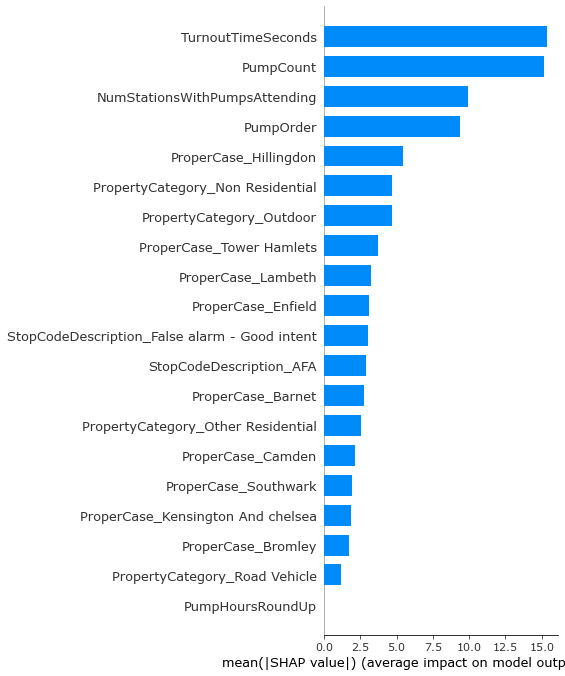

In [88]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

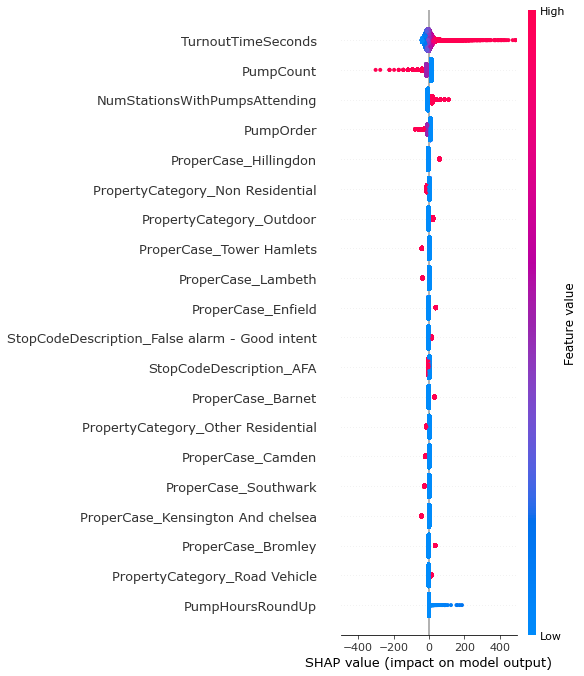

In [14]:
plt.xlim(-500, 500)
shap.summary_plot(shap_values, X_test)


### Shap sample

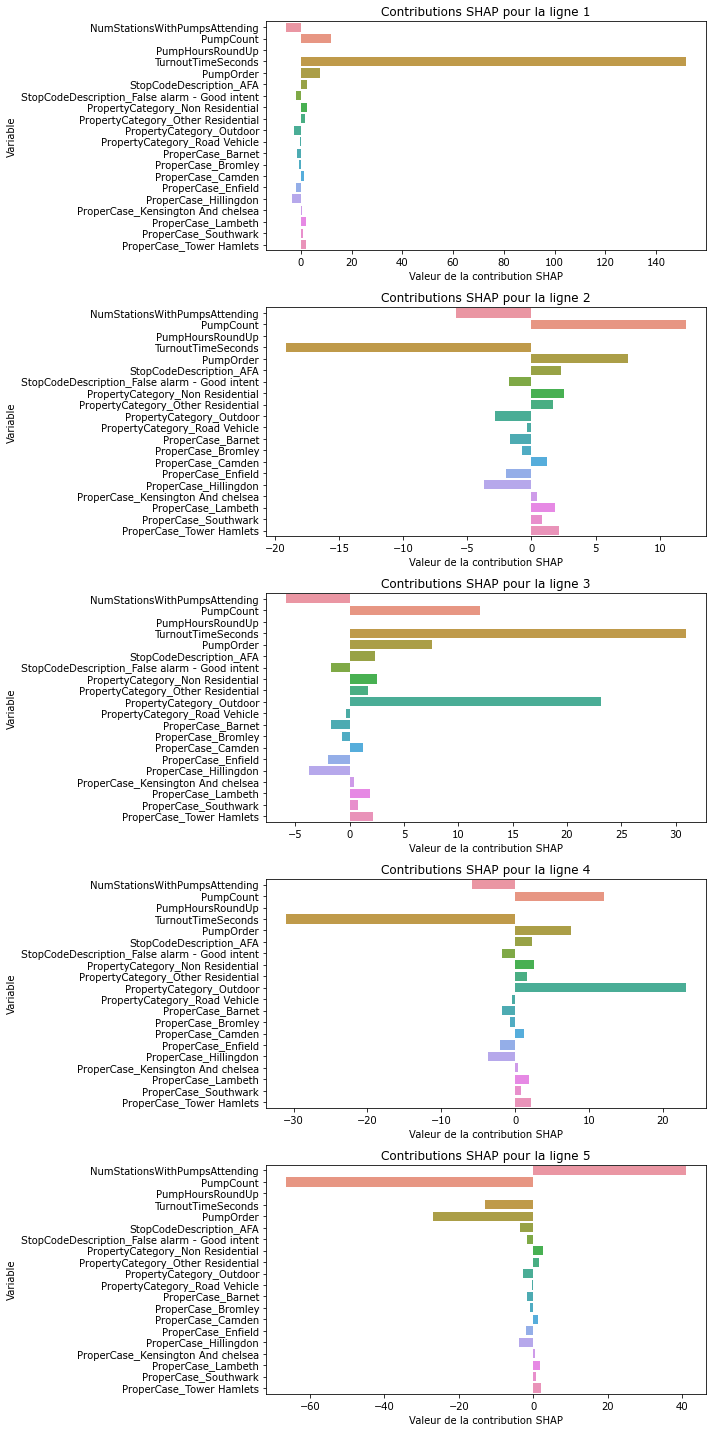

In [87]:

# Sélectionner quelques lignes au hasard
rows_to_plot = shap_df.sample(n=5)  

# Nombre de variables
num_variables = len(shap_df.columns) - 1  # - 1 pour exclure la variable cible

# Ajuster la taille de la figure en fonction du nombre de variables
plt.figure(figsize=(10, 4 * len(rows_to_plot)))

# Créer un graphique pour chaque ligne sélectionnée
for i, (_, row) in enumerate(rows_to_plot.iterrows(), 1):
    plt.subplot(len(rows_to_plot), 1, i)
    sns.barplot(x=row.values[:-1], y=row.index[:-1], orient='h')
    plt.title(f'Contributions SHAP pour la ligne {i}')
    plt.xlabel('Valeur de la contribution SHAP')
    plt.ylabel('Variable')

plt.tight_layout()  # Ajuster les espacements entre les sous-graphiques
plt.show()
